In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
from os.path import join
import torch
import torch as th
import seaborn as sns
import matplotlib.pyplot as plt
import sys
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation/PixArt-alpha")
from diffusion import IDDPM
from diffusion.data.builder import build_dataset, build_dataloader, set_data_root
from diffusion.model.builder import build_model
from diffusion.utils.misc import set_random_seed, read_config, init_random_seed, DebugUnderflowOverflow
sys.path.append("/n/home12/binxuwang/Github/DiffusionObjectRelation")
from utils.pixart_sampling_utils import pipeline_inference_custom, \
    PixArtAlphaPipeline_custom
from utils.pixart_utils import state_dict_convert
from utils.text_encoder_control_lib import RandomEmbeddingEncoder_wPosEmb
from utils.image_utils import pil_images_to_grid
from utils.attention_map_store_utils import replace_attn_processor, AttnProcessor2_0_Store, PixArtAttentionVisualizer_Store
from utils.cv2_eval_utils import find_classify_object_masks
from diffusers import AutoencoderKL, Transformer2DModel, PixArtAlphaPipeline, DPMSolverMultistepScheduler
from transformers import T5Tokenizer, T5EncoderModel

/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/mmcv/__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/utils/hub.py:127: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
savedir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/results/objrel_rndembdposemb_DiT_B_pilot"

config = read_config(join(savedir, 'config.py'))

weight_dtype = torch.float32
if config.mixed_precision == "fp16": # accelerator.
    weight_dtype = torch.float16
elif config.mixed_precision == "bf16": # accelerator.
    weight_dtype = torch.bfloat16
    
image_size = config.image_size  # @param [256, 512, 1024]
latent_size = int(image_size) // 8
pred_sigma = getattr(config, 'pred_sigma', True)
learn_sigma = getattr(config, 'learn_sigma', True) and pred_sigma
model_kwargs={"window_block_indexes": config.window_block_indexes, "window_size": config.window_size,
                "use_rel_pos": config.use_rel_pos, "lewei_scale": config.lewei_scale, 'config':config,
                'model_max_length': config.model_max_length}
# train_diffusion = IDDPM(str(config.train_sampling_steps), learn_sigma=learn_sigma, pred_sigma=pred_sigma, snr=config.snr_loss)
model = build_model(config.model,
                config.grad_checkpointing,
                config.get('fp32_attention', False),
                input_size=latent_size,
                learn_sigma=learn_sigma,
                pred_sigma=pred_sigma,
                **model_kwargs).train()

transformer = Transformer2DModel(
        sample_size=image_size // 8,
        num_layers=len(model.blocks),
        attention_head_dim=model.blocks[0].hidden_size // model.num_heads,
        in_channels=model.in_channels,
        out_channels=model.out_channels,
        patch_size=model.patch_size,
        attention_bias=True,
        num_attention_heads=model.num_heads,
        cross_attention_dim=model.blocks[0].hidden_size,
        activation_fn="gelu-approximate",
        num_embeds_ada_norm=1000,
        norm_type="ada_norm_single",
        norm_elementwise_affine=False,
        norm_eps=1e-6,
        caption_channels=4096,
)
# state_dict = state_dict_convert(all_state_dict.pop("state_dict"))
transformer.load_state_dict(state_dict_convert(model.state_dict()))
pipeline = PixArtAlphaPipeline_custom.from_pretrained(
    "PixArt-alpha/PixArt-XL-2-512x512",
    transformer=transformer,
    tokenizer=None,
    text_encoder=None,
    torch_dtype=weight_dtype,
)

2025-07-01 17:35:53,634 - PixArt - WARNING - lewei scale: (1.0,), base size: 8


Loading pipeline components...:   0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
ckptdir = join(savedir, "checkpoints")
ckpt = torch.load(join(ckptdir, "epoch_4000_step_160000.pth"))
pipeline.transformer.load_state_dict(state_dict_convert(ckpt['state_dict_ema']))

<All keys matched successfully>

In [6]:
print(config.pretty_text)

data_root = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt'
data = dict(
    type='InternalData',
    root=
    '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndembposemb',
    image_list_json=['data_info.json'],
    transform='default_train',
    load_vae_feat=True,
    max_length=20)
image_size = 128
train_batch_size = 256
eval_batch_size = 16
use_fsdp = False
valid_num = 0
model = 'PixArt_B_2'
aspect_ratio_type = None
multi_scale = False
lewei_scale = 1.0
num_workers = 10
train_sampling_steps = 1000
eval_sampling_steps = 250
model_max_length = 20
lora_rank = 4
num_epochs = 4000
gradient_accumulation_steps = 1
grad_checkpointing = True
gradient_clip = 0.01
gc_step = 1
auto_lr = dict(rule='sqrt')
optimizer = dict(type='AdamW', lr=0.0001, weight_decay=0.03, eps=1e-10)
lr_schedule = 'constant'
lr_schedule_args = dict(num_warmup_steps=500)
save_image_epochs = 1
save_model_epochs = 50
save_model_steps = 2000


In [7]:
text_feat_dir_old = '/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objectRel_pilot_rndemb/caption_feature_wmask'
emb_data = th.load(join(text_feat_dir_old, "word_embedding_dict.pt"))
rndpos_encoder = RandomEmbeddingEncoder_wPosEmb(emb_data["embedding_dict"], 
                                              emb_data["input_ids2dict_ids"], 
                                              emb_data["dict_ids2input_ids"], 
                                              max_seq_len=20, embed_dim=4096,
                                              wpe_scale=1/6).to("cuda")

In [8]:
T5_path = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/output/pretrained_models/t5_ckpts/t5-v1_1-xxl"
tokenizer = T5Tokenizer.from_pretrained(T5_path, )#subfolder="tokenizer")
# encoder = T5EncoderModel.from_pretrained(T5_path)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/n/home12/binxuwang/.conda/envs/torch2/lib/python3.10/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [11]:
pipeline.tokenizer = tokenizer
pipeline.text_encoder = rndpos_encoder
pipeline.to(device="cuda", dtype=weight_dtype);

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/30 [00:00<?, ?it/s]

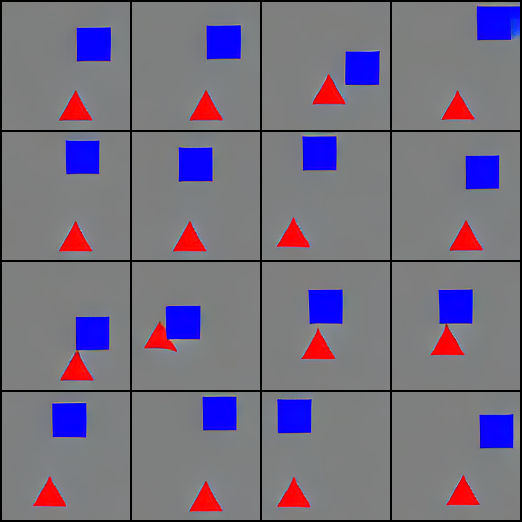

In [12]:
# pipeline.transformer = pipeline.transformer.to(device="cuda", dtype=weight_dtype)
# pipeline.text_encoder = rndpos_encoder.to(device="cuda", dtype=weight_dtype)
output = pipeline("red triangle below and to the left of blue square", 
        num_inference_steps=30,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        device="cuda")
display(pil_images_to_grid(output.images))

In [13]:
pipeline.transformer = replace_attn_processor(pipeline.transformer)
attnvis_store = PixArtAttentionVisualizer_Store(pipeline)
attnvis_store.setup_hooks()

Setting up hooks for PixArt attention modules:
- Block 0
- Block 1
- Block 2
- Block 3
- Block 4
- Block 5
- Block 6
- Block 7
- Block 8
- Block 9
- Block 10
- Block 11


torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

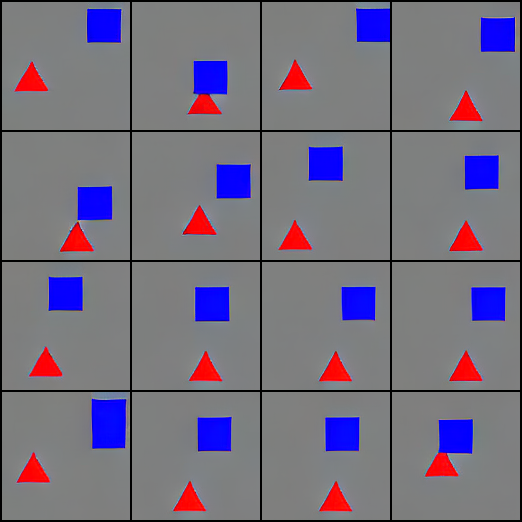

In [61]:
attnvis_store.clear_activation()
output = pipeline("red triangle below and to the left of blue square", 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [62]:
attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_self_attn_map'], dim=0) for layer_i in range(12)]
attn_map_stacked = th.stack(attn_map_stacked, dim=0)
cross_attn_map_stacked = [th.stack(attnvis_store.activation[f'block{layer_i:02d}_cross_attn_map'], dim=0) for layer_i in range(12)]
cross_attn_map_stacked = th.stack(cross_attn_map_stacked, dim=0)
print("attn_map_stacked.shape: ", attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_tokens)
print("cross_attn_map_stacked.shape: ", cross_attn_map_stacked.shape) # (num_layers, num_steps, num_images * 2, num_heads, num_tokens, num_word_tokens)

attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 64])
cross_attn_map_stacked.shape:  torch.Size([12, 14, 32, 12, 64, 20])


### Search for attention maps that match a certain template

In [65]:
import matplotlib.pyplot as plt
import torch as th
from utils.attention_analysis_lib import plot_attention_layer_head_heatmaps
from utils.attention_analysis_lib import *
from circuit_toolkit.plot_utils import saveallforms
figdir = "/n/holylfs06/LABS/kempner_fellow_binxuwang/Users/binxuwang/DL_Projects/PixArt/objrel_rndembdposemb_DiT_B_pilot/attn_vis_figs"
os.makedirs(figdir, exist_ok=True)

In [41]:
map_shape = (8,8)
H, W = map_shape
num_tokens = H * W
attn_tsr_template = th.zeros((H, W, H, W))
shifts = [(0, 1),]
density = 1 / len(shifts)
for i in range(H):
    for j in range(W):
        for shift_i, shift_j in shifts: 
            i_new, j_new = i + shift_i, j + shift_j
            if i_new >= H or j_new >= W or i_new < 0 or j_new < 0:
                continue
            attn_tsr_template[i, j, i_new, j_new] = density
attn_mat_template = attn_tsr_template.reshape(H * W, H * W)
# attn_mat_template = attn_mat_template / attn_mat_template.sum(dim=1, keepdim=True)
print("attn_tsr_template.shape: ", attn_tsr_template.shape)
print("attn_mat_template.shape: ", attn_mat_template.shape)

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


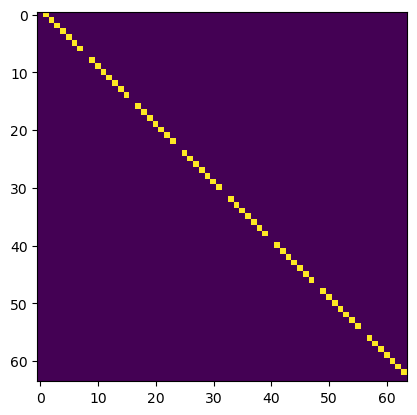

In [47]:
plt.imshow(attn_mat_template)
plt.show()

In [50]:
def build_template_conv_attn_map(shifts=[(0, 1),], map_shape=(8,8), density=None):
    # shifts = [(0, 1),]
    # density = 1 / len(shifts)
    H, W = map_shape
    num_tokens = H * W
    attn_tsr_template = th.zeros((H, W, H, W))
    if density is None:
        density_list = [1 / len(shifts)] * len(shifts)
    for i in range(H):
        for j in range(W):
            for (shift_i, shift_j), density in zip(shifts, density_list): 
                i_new, j_new = i + shift_i, j + shift_j
                if i_new >= H or j_new >= W or i_new < 0 or j_new < 0:
                    continue
                attn_tsr_template[i, j, i_new, j_new] = density
    attn_mat_template = attn_tsr_template.reshape(H * W, H * W)
    # attn_mat_template = attn_mat_template / attn_mat_template.sum(dim=1, keepdim=True)
    print("attn_tsr_template.shape: ", attn_tsr_template.shape)
    print("attn_mat_template.shape: ", attn_mat_template.shape)
    return attn_mat_template, attn_tsr_template

In [205]:
def plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max", step_id=None):
    n_samples = template_similarity_scores.shape[1] // 2
    cond_slice = slice(n_samples, n_samples * 2)
    uncond_slice = slice(0, n_samples)
    if step_sum_type == "max":
        temporal_summary = template_similarity_scores.max(dim=1).values
    elif step_sum_type == "mean":
        temporal_summary = template_similarity_scores.mean(dim=1)
    elif step_sum_type == "index" and step_id is not None:
        temporal_summary = template_similarity_scores[:, step_id, :, :]
    else:
        raise ValueError(f"Invalid step_sum_type: {step_sum_type}")
    layer_head_summary = temporal_summary[:, cond_slice, :].mean(dim=-2).numpy() # average over samples 
    fig = plt.figure(figsize=(10, 4.5))
    plt.subplot(1, 2, 1)
    sns.heatmap(layer_head_summary)
    plt.title("Cond pass")
    plt.axis('image')
    plt.ylabel("Layer")
    plt.xlabel("Head")
    plt.subplot(1, 2, 2)
    layer_head_summary = temporal_summary[:, uncond_slice, :].mean(dim=-2).numpy() # average over samples 
    sns.heatmap(layer_head_summary)
    plt.title("Uncond pass")
    plt.axis('image')
    plt.ylabel("Layer")
    plt.xlabel("Head")
    plt.suptitle(f"Attention template similarity Layer-Head Summary | {step_sum_type} over steps | {template_type} ")
    plt.show()
    return fig

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


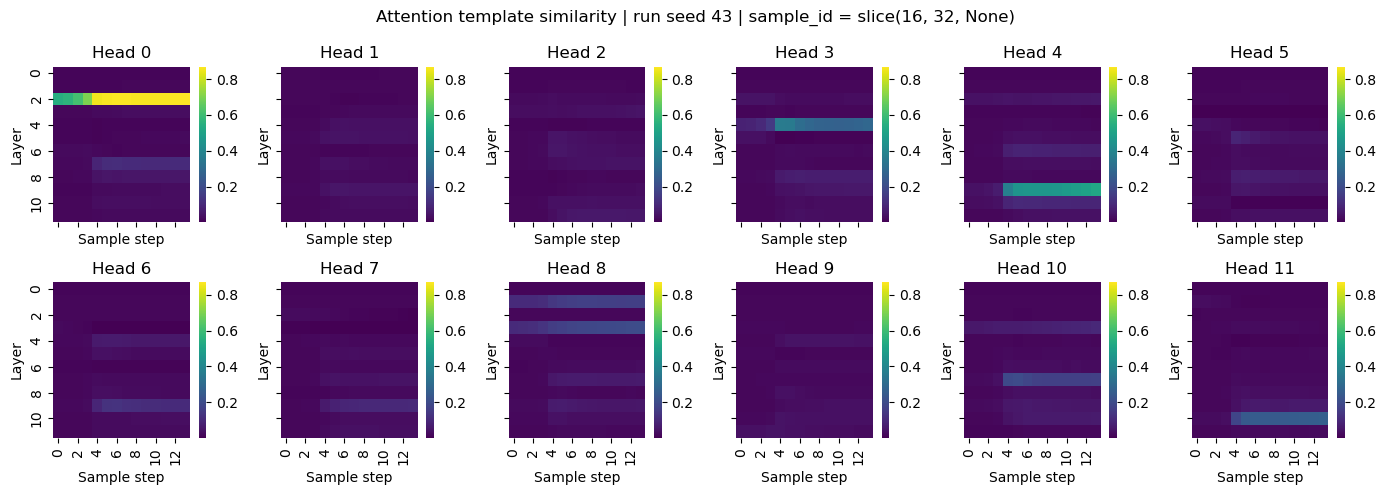

Computed attn entropy


In [ ]:
attn_mat_template, _ = build_template_conv_attn_map(shifts=[(0, -1),], )
template_similarity_scores = (attn_map_stacked * attn_mat_template).sum(dim=-1).mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                         title_str="Attention template similarity | run seed 43", 
                                         figsize=(14, 5), sample_idx=slice(16, 32), num_heads=12, share_clim=True, panel_shape=(2, 6))
print("Computed attn entropy")

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


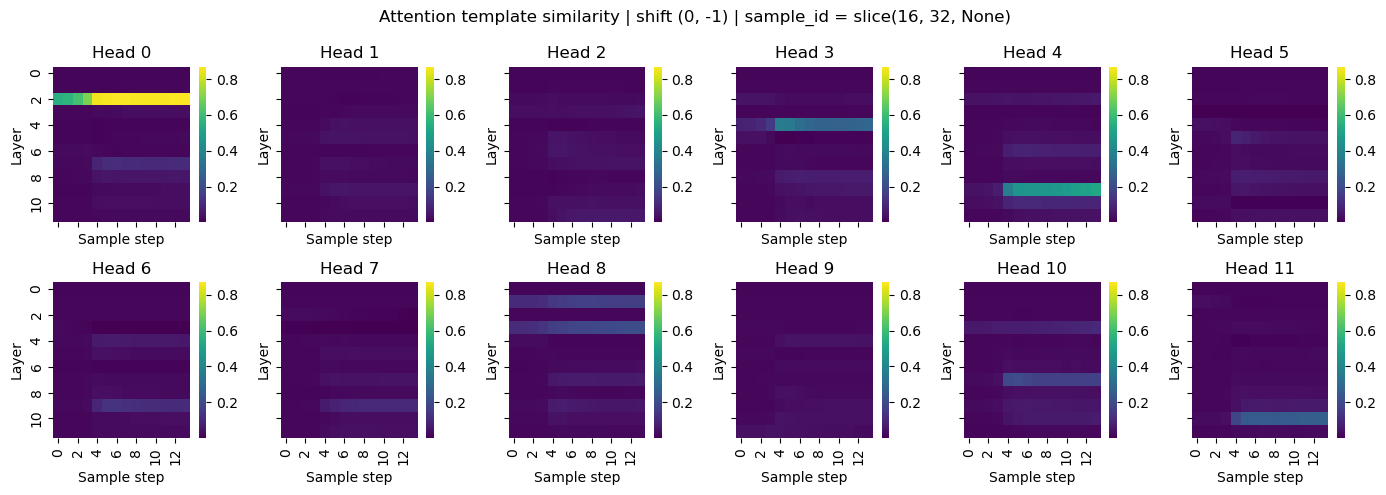

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


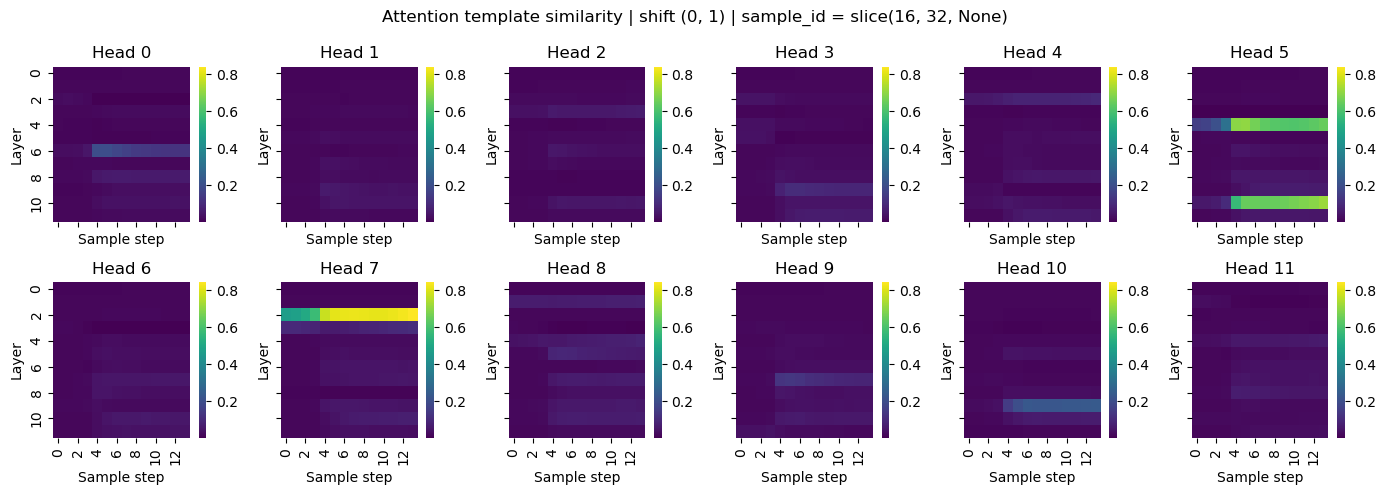

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


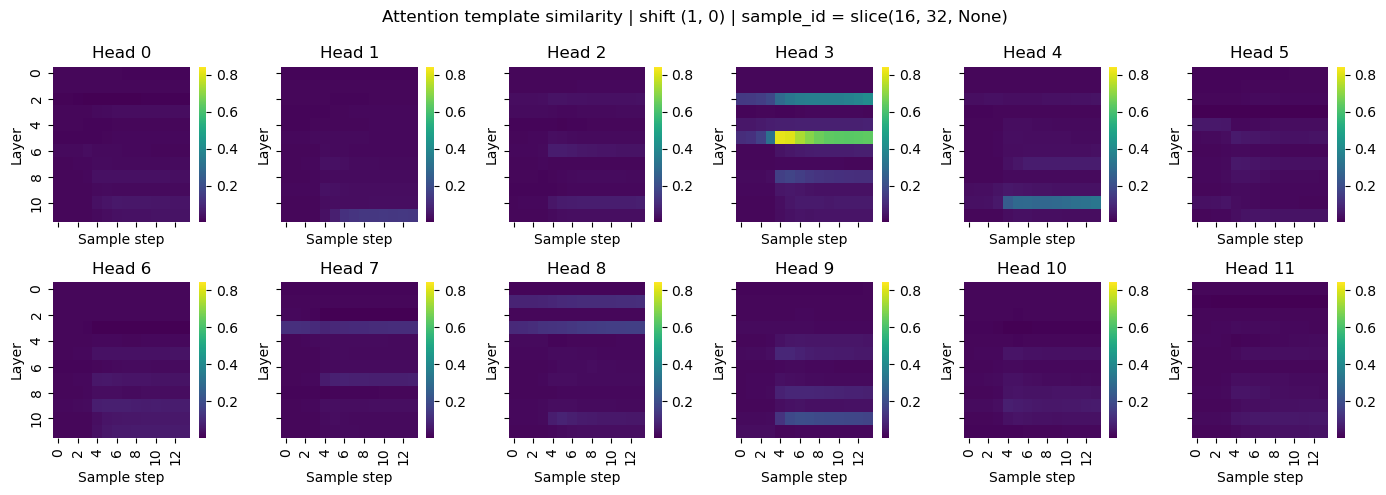

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


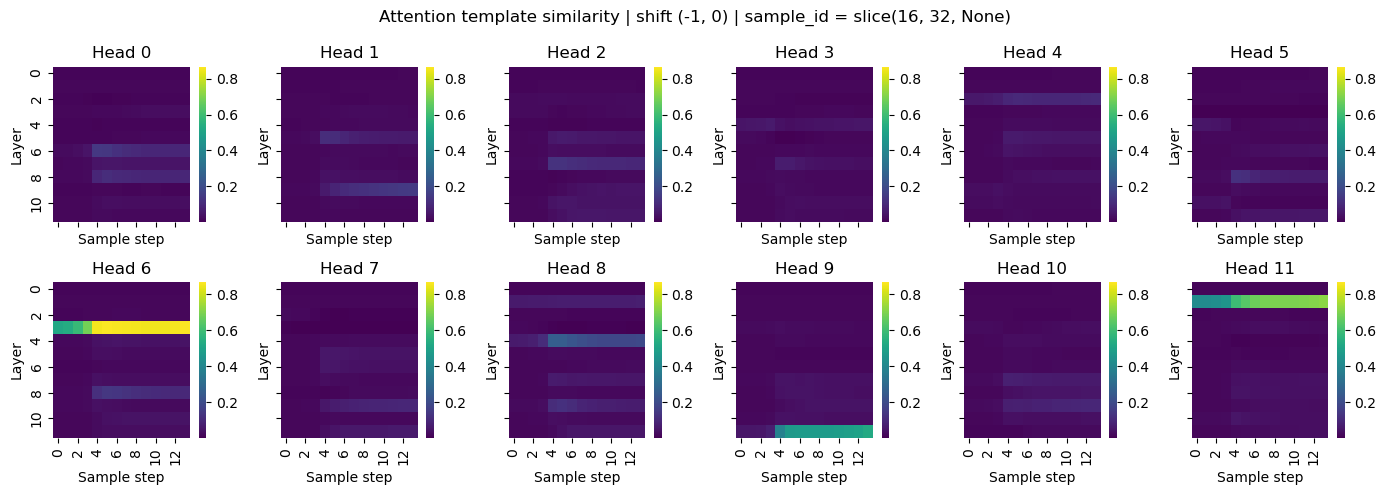

In [66]:
n_samples = 16
for shift in [(0, -1), (0, 1), (1, 0), (-1, 0)]:
    attn_mat_template, _ = build_template_conv_attn_map(shifts=[shift], )
    template_similarity_scores = (attn_map_stacked * attn_mat_template).sum(dim=-1).mean(dim=-1)
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                         title_str=f"Attention template similarity | shift {shift}", 
                                         figsize=(14, 5), sample_idx=slice(n_samples, n_samples * 2), num_heads=12, share_clim=True, panel_shape=(2, 6))
    saveallforms(figdir, f"attn_template_similarity_shift_{shift}", fig)

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


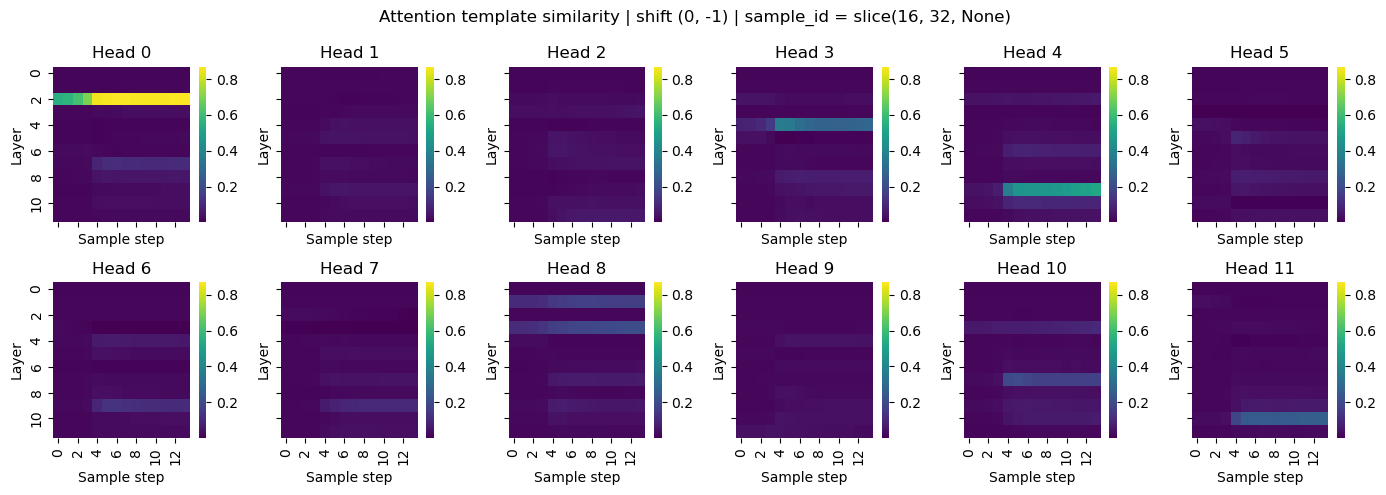

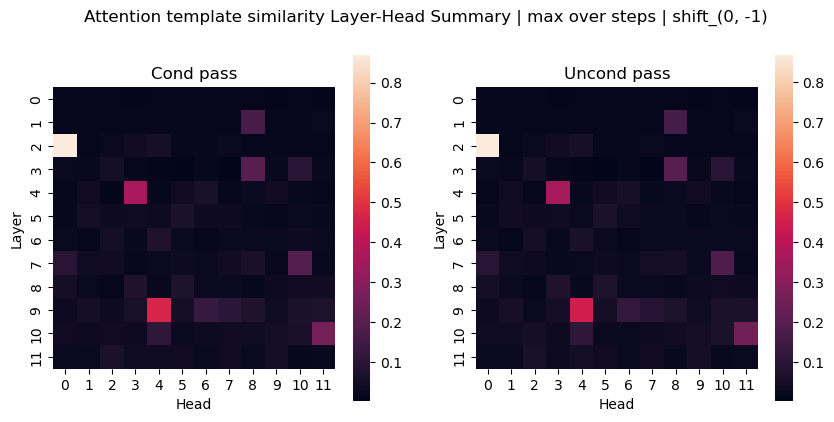

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


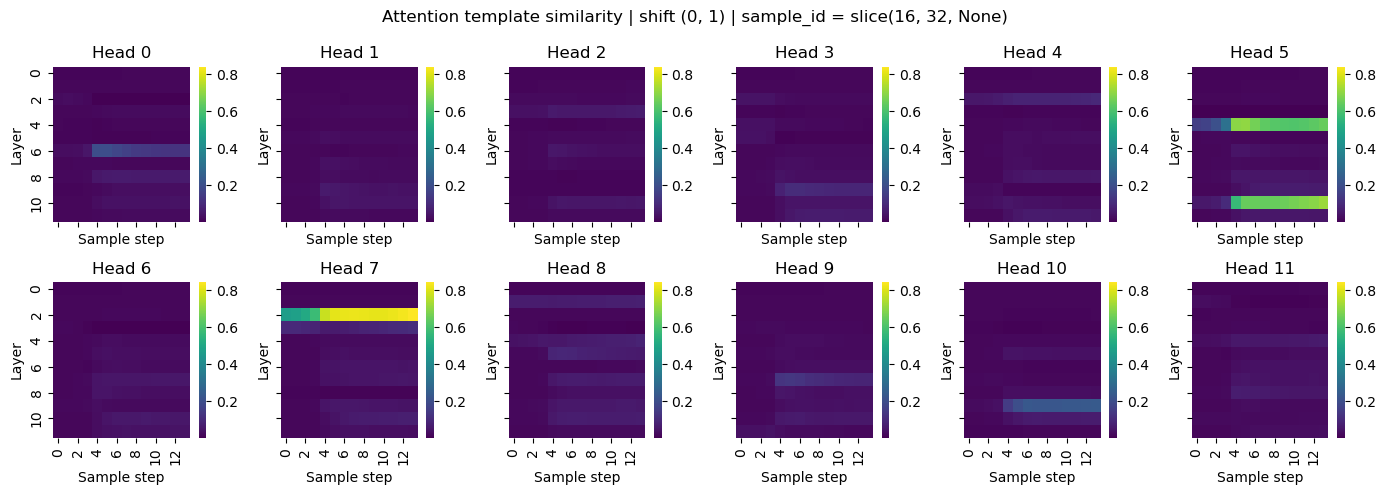

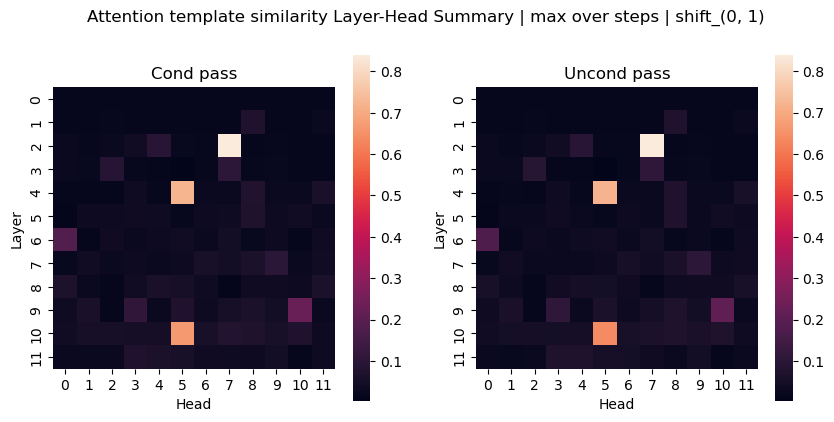

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


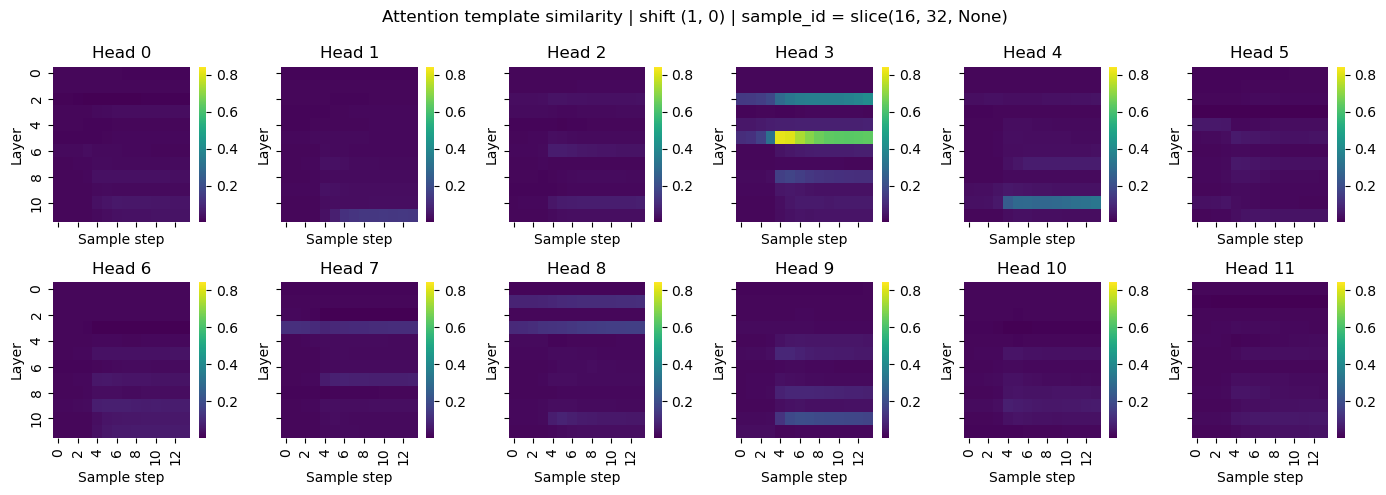

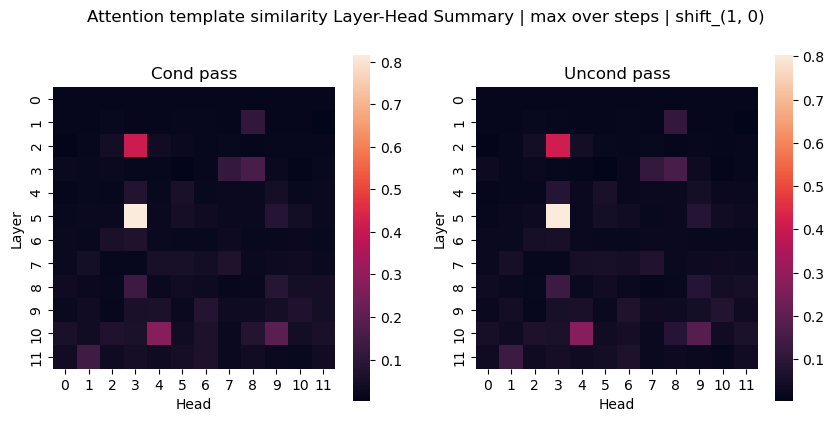

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


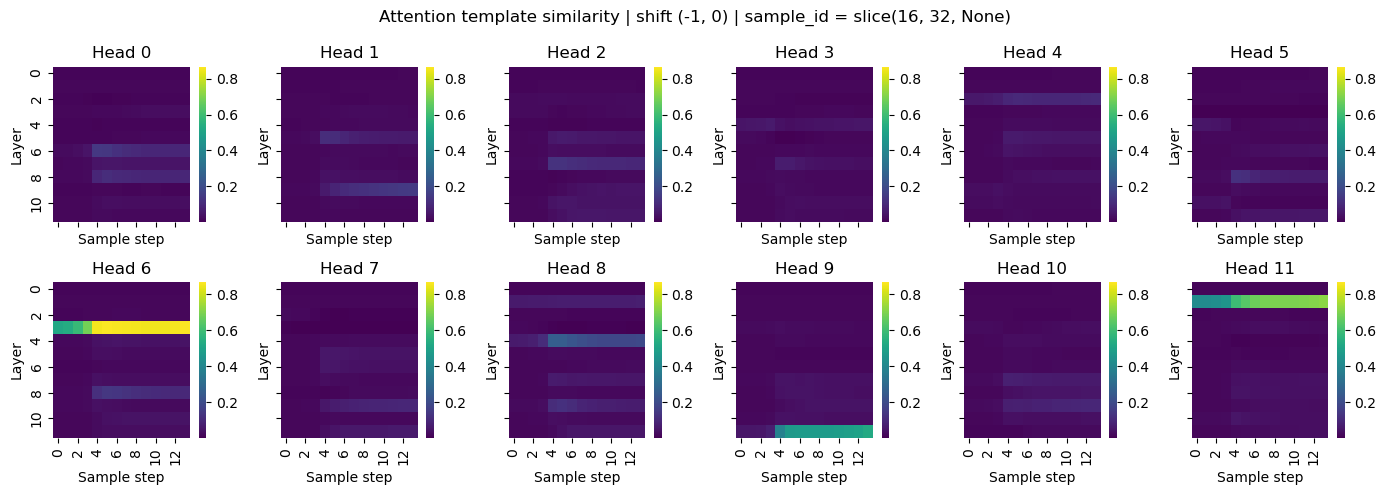

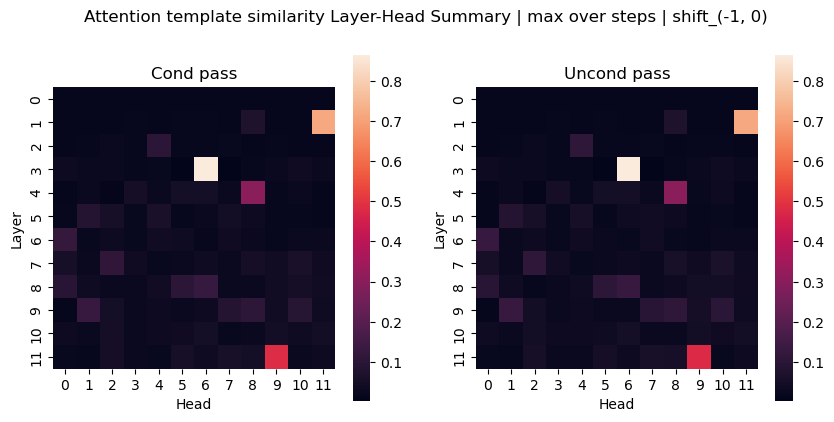

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


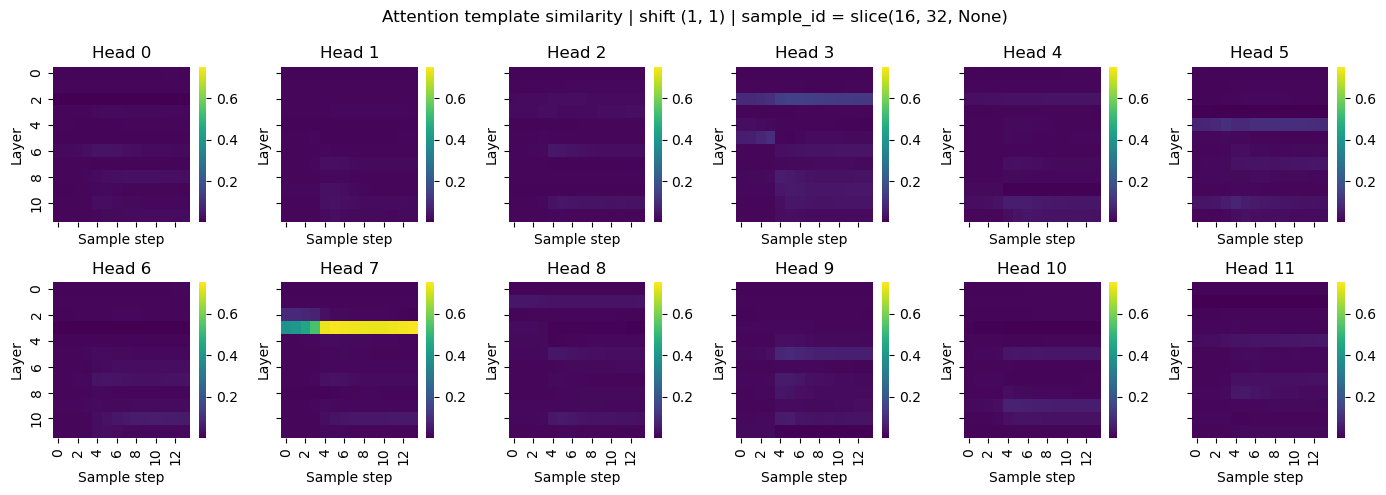

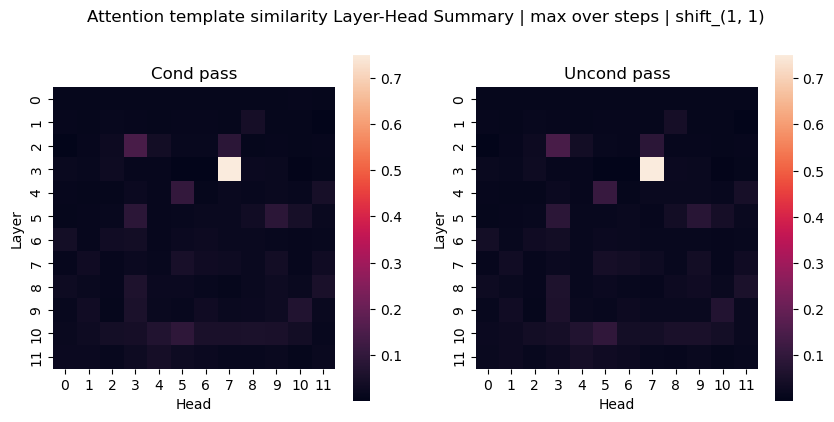

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


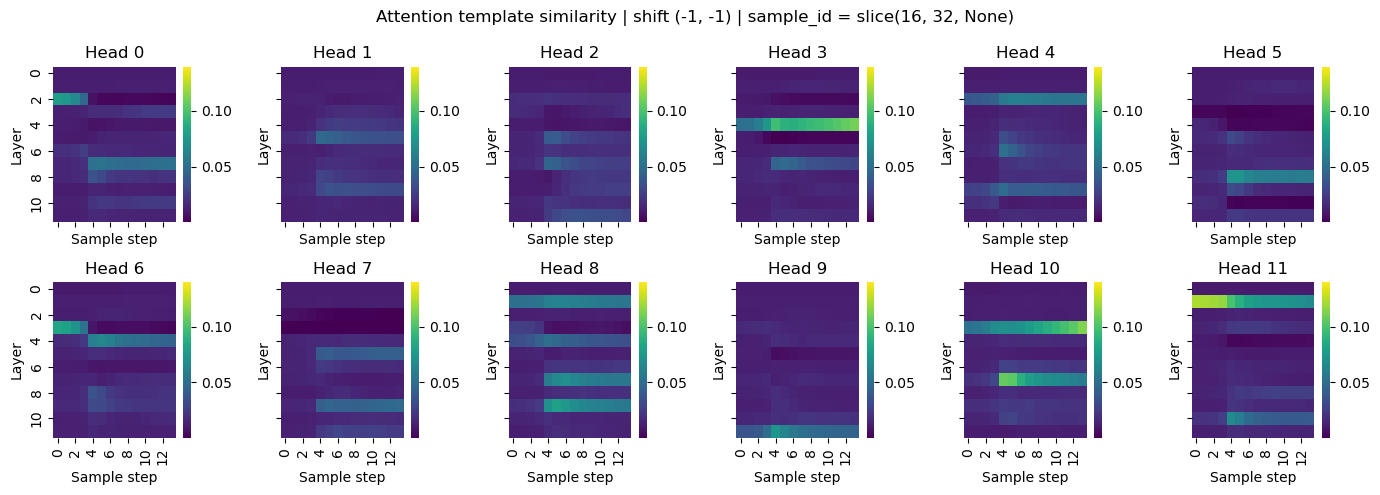

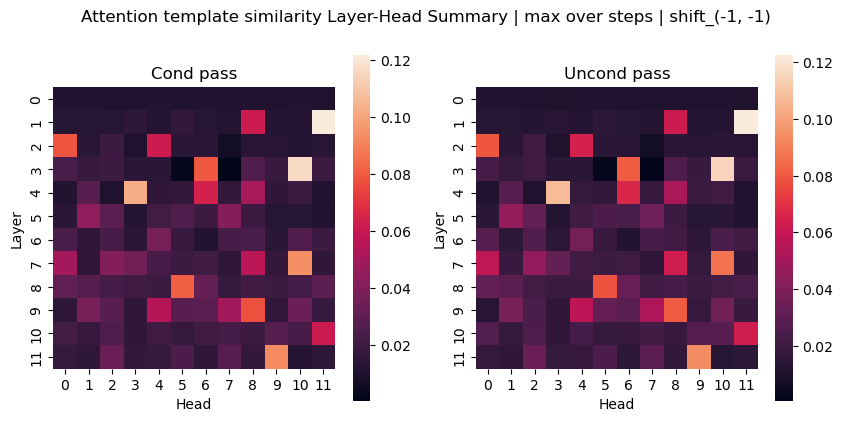

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


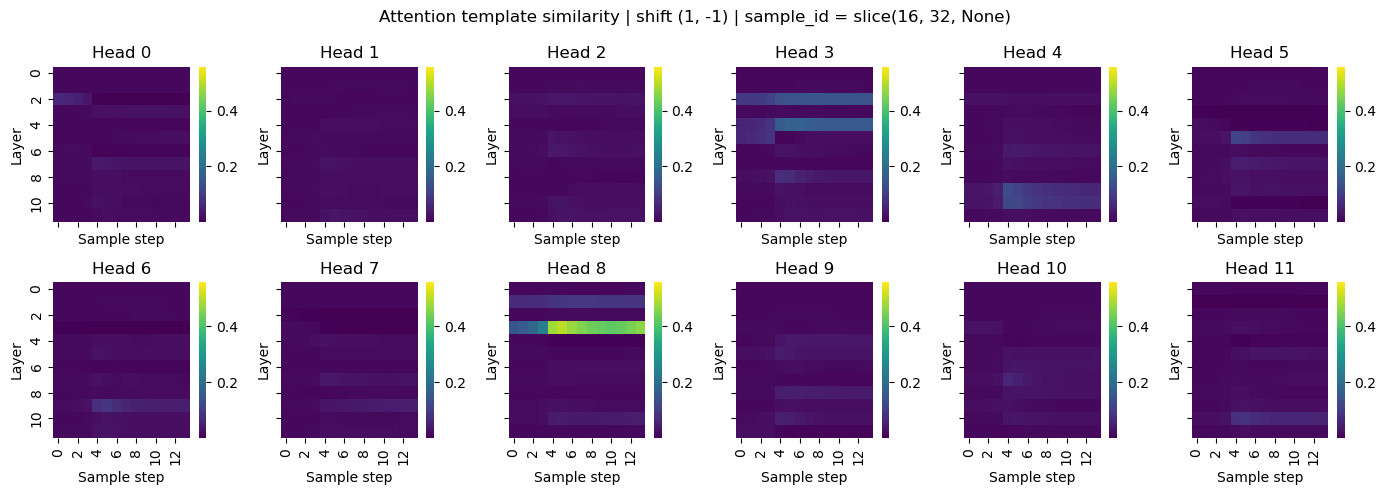

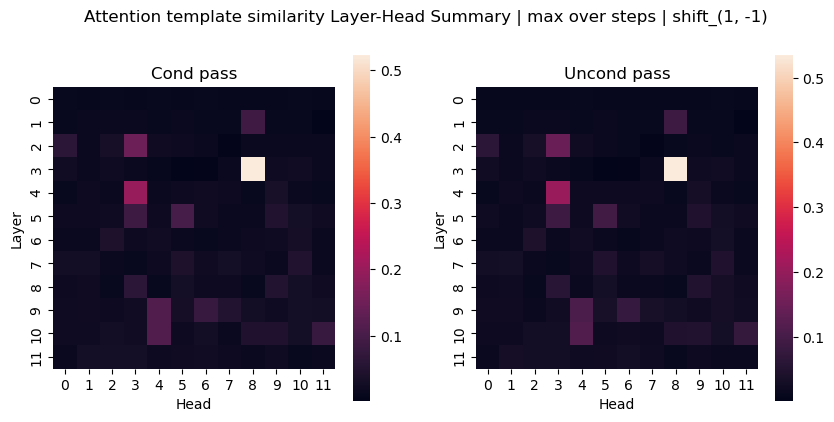

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


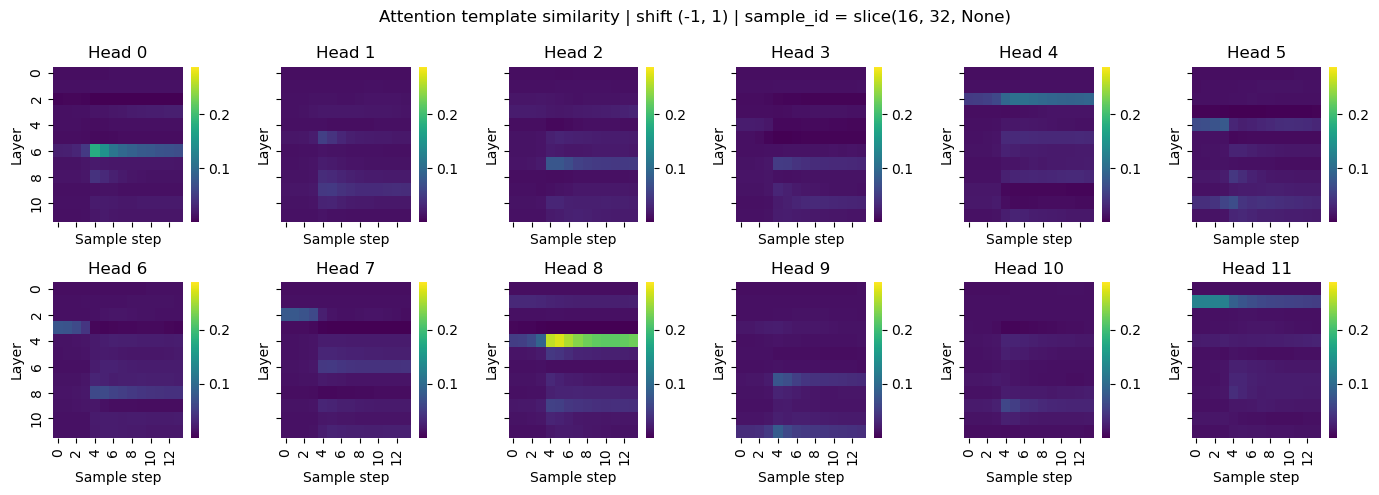

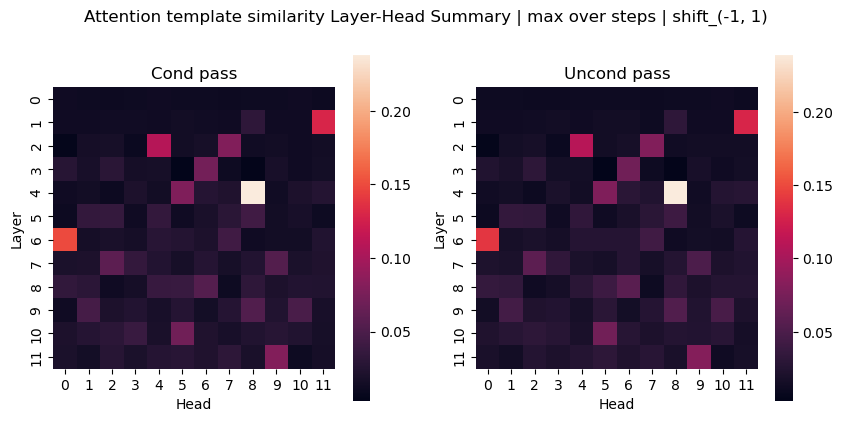

In [206]:

n_samples = 16
for shift in [(0, -1), (0, 1), (1, 0), (-1, 0), (1, 1), (-1, -1), (1, -1), (-1, 1)]:
    attn_mat_template, _ = build_template_conv_attn_map(shifts=[shift], )
    template_similarity_scores = (attn_map_stacked * attn_mat_template).sum(dim=-1).mean(dim=-1)
    fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                         title_str=f"Attention template similarity | shift {shift}", 
                                         figsize=(14, 5), sample_idx=slice(n_samples, n_samples * 2), num_heads=12, share_clim=True, panel_shape=(2, 6))
    saveallforms(figdir, f"attn_template_similarity_shift_{shift}", fig)
    fig2 = plot_layer_head_score_summary(template_similarity_scores, f"shift_{shift}", step_sum_type="max")
    saveallforms(figdir, f"attn_template_similarity_shift_{shift}_layer_head_summary", fig2)

### Object centric attention

In [ ]:
from utils.cv2_eval_utils import find_classify_object_masks
import numpy as np
import seaborn as sns
from tqdm.auto import trange
import matplotlib.pyplot as plt

torch.Size([32, 20, 4096])
torch.Size([32, 20])


  0%|          | 0/14 [00:00<?, ?it/s]

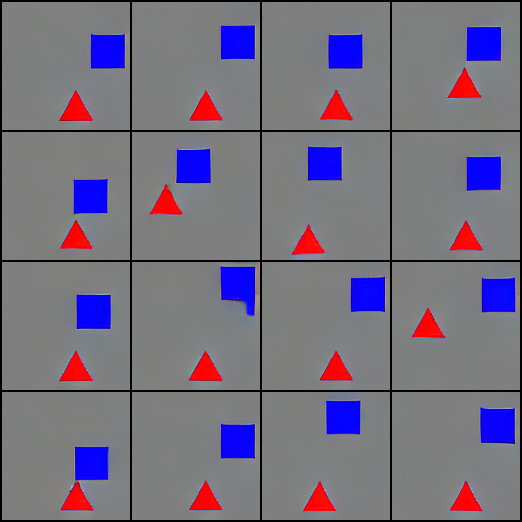

In [67]:
attnvis_store.clear_activation()
output = pipeline("red triangle below and to the left of blue square", 
        num_inference_steps=14,
        max_sequence_length=20, 
        num_images_per_prompt=16,
        return_sample_pred_traj=True,
        device="cuda")
pred_traj, latents_traj, t_traj = output[1], output[2], output[3]
display(pil_images_to_grid(output[0].images))

In [69]:
output[0].images

[<PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>,
 <PIL.Image.Image image mode=RGB size=128x128>]

In [89]:
import cv2
positive_threshold = 180

In [90]:
df, object_masks = find_classify_object_masks(output[0].images[0])
# object_masks is a list of binary masks (numpy arrays) for each detected object

In [94]:
df

Object     Shape  Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle  (247, 4, 7)   (74, 102.0)   458.5     443.405007
1      15    Square  (7, 1, 250)     (106, 49)  1030.0    1024.000000

In [91]:
obj_masks_resized = [cv2.resize(obj_mask, (8, 8)) for obj_mask in object_masks]
obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]

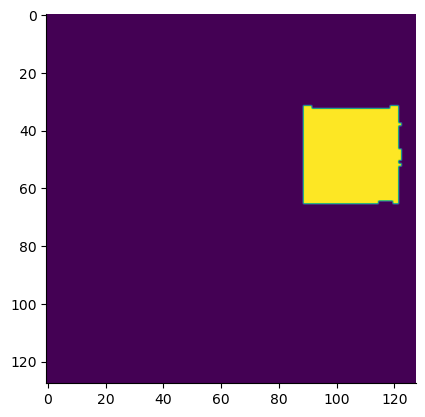

In [ ]:
plt.imshow(object_masks[1])
plt.show()

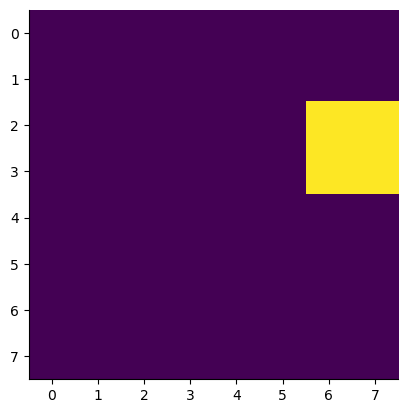

In [92]:
plt.imshow(obj_masks_resized_binary[1])

In [93]:
obj_masks_resized_binary[0]

array([[False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False, False, False, False, False],
       [False, False, False, False,  True, False, False, False],
       [False, False, False, False, False, False, False, False]])

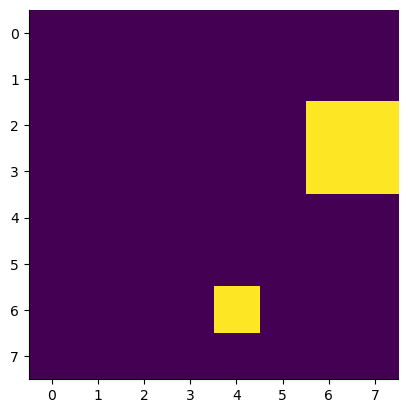

In [ ]:


object_mask_combined = np.zeros((8, 8))
for obj_mask in obj_masks_resized_binary:
    object_mask_combined += obj_mask
plt.imshow(object_mask_combined)
plt.show()

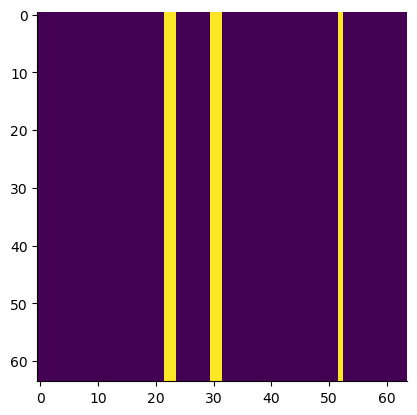

In [102]:
object_mask_combined_vec = object_mask_combined.reshape(-1)
H, W = 8, 8
n_tokens = H * W
attn_template_every_tok_2_obj = th.zeros((n_tokens, n_tokens))
attn_template_every_tok_2_obj[:, :] = th.from_numpy(object_mask_combined_vec)[None, :] / object_mask_combined_vec.sum()
attn_template_every_tok_2_obj
plt.imshow(attn_template_every_tok_2_obj)
plt.show()

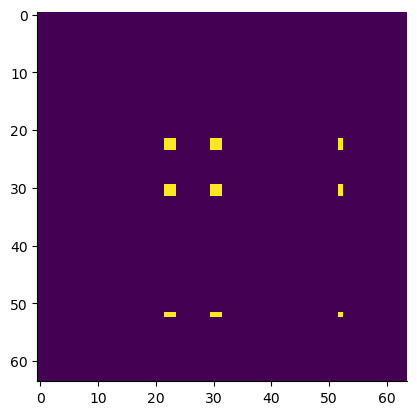

In [103]:
# attn_template_obj_specific = th.zeros((8, 8, 8, 8))
attn_template_obj_2_obj = object_mask_combined_vec[:,None] @ object_mask_combined_vec[None, :] / object_mask_combined_vec.sum()
plt.imshow(attn_template_obj_2_obj)
plt.show()

In [134]:
df

Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle   (248, 5, 9)   (74, 103.0)   429.5     443.405007
1      13    Square  (12, 4, 250)     (105, 33)  1064.5    1024.000000

In [137]:
df.query("Shape == 'Triangle'")

Object     Shape  Color (RGB) Center (x, y)   Area  Expected Area
0       1  Triangle  (248, 5, 9)   (74, 103.0)  429.5     443.405007

In [138]:
df.query("Shape == 'Square'")

Object   Shape   Color (RGB) Center (x, y)    Area  Expected Area
1      13  Square  (12, 4, 250)     (105, 33)  1064.5         1024.0

In [139]:
df.query("Shape == 'Triangle'").index[0]

0

In [140]:
df.query("Shape == 'Square'").index[0]

1

In [144]:
df

Object     Shape   Color (RGB) Center (x, y)    Area  Expected Area
0       1  Triangle   (249, 5, 7)   (74, 102.0)   458.5     443.405007
1      13    Circle  (10, 2, 249)     (105, 29)  1171.5     804.247719

  0%|          | 0/16 [00:00<?, ?it/s]

Failed to generate template for sample 9


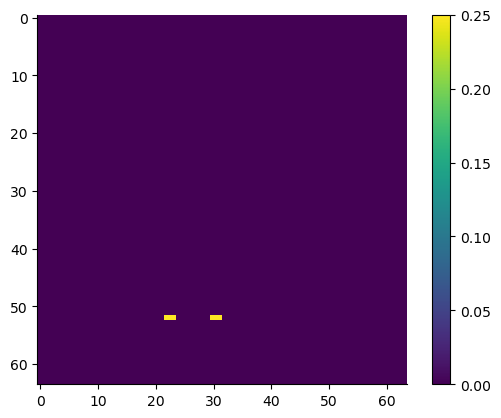

In [157]:
H, W = 8, 8
template_type = "every_tok_2_obj"
template_type = "triangle2square"
n_tokens = H * W
attn_template_tsr = th.zeros((len(output[0].images), n_tokens, n_tokens))
failed_samples = []
for sample_i in trange(len(output[0].images)):
    df, object_masks = find_classify_object_masks(output[0].images[sample_i])
    obj_masks_resized = [cv2.resize(obj_mask, (H, W)) for obj_mask in object_masks]
    obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
    try:
        assert len(object_masks) == 2
        all_obj_masks = np.zeros((H, W,))
        for obj_mask_resized_binary in obj_masks_resized_binary:
            all_obj_masks = np.logical_or(all_obj_masks, obj_mask_resized_binary)
        all_obj_mask_vec = all_obj_masks.reshape(-1)
        if template_type == "obj_2_obj":
            attn_template_every_tok_2_obj = all_obj_mask_vec[:,None] / all_obj_mask_vec.sum() @ all_obj_mask_vec[None, :] / all_obj_mask_vec.sum()
        elif template_type == "every_tok_2_obj":
            attn_template_every_tok_2_obj = np.ones(n_tokens)[:, None] / n_tokens @ all_obj_mask_vec[None, :] / all_obj_mask_vec.sum()
        elif template_type == "triangle2square":
            triangle_idx = df.query("Shape == 'Triangle'").index[0]
            square_idx = df.query("Shape == 'Square'").index[0]
            triangle_mask = obj_masks_resized_binary[triangle_idx].astype(float).flatten()
            square_mask = obj_masks_resized_binary[square_idx].astype(float).flatten()
            attn_template_every_tok_2_obj = triangle_mask[:,None] / triangle_mask.sum() @ square_mask[None, :] / square_mask.sum()
        elif template_type == "square2triangle":
            triangle_idx = df.query("Shape == 'Triangle'").index[0]
            square_idx = df.query("Shape == 'Square'").index[0]
            triangle_mask = obj_masks_resized_binary[triangle_idx].astype(float).flatten()
            square_mask = obj_masks_resized_binary[square_idx].astype(float).flatten()
            attn_template_every_tok_2_obj = square_mask[:,None] / square_mask.sum() @ triangle_mask[None, :] / triangle_mask.sum()
        else:
            raise ValueError(f"Invalid template type: {template_type}")
        attn_template_tsr[sample_i, :, :] = th.from_numpy(attn_template_every_tok_2_obj)
    except:
        print(f"Failed to generate template for sample {sample_i}")
        failed_samples.append(sample_i)
        continue
success_count = len(output[0].images) - len(failed_samples)
plt.imshow(attn_template_tsr[0, :, :])
plt.colorbar()
plt.show()

  0%|          | 0/16 [00:00<?, ?it/s]

Failed to generate template for sample 9


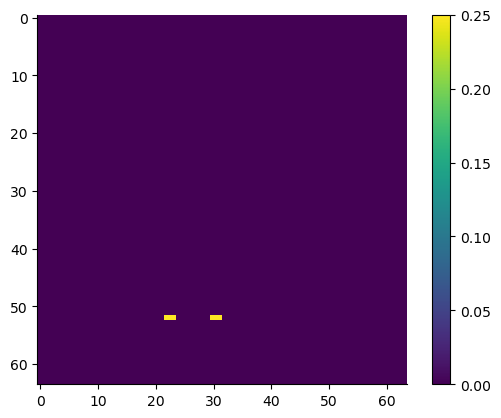

In [165]:
def create_object_based_attention_template(image_list, template_type, map_shape=(8, 8), positive_threshold=180,):
    n_tokens = H * W
    attn_template_tsr = th.zeros((len(image_list), n_tokens, n_tokens))
    failed_samples = []
    for sample_i in trange(len(image_list)):
        df, object_masks = find_classify_object_masks(image_list[sample_i])
        obj_masks_resized = [cv2.resize(obj_mask, (H, W)) for obj_mask in object_masks]
        obj_masks_resized_binary = [obj_mask > positive_threshold for obj_mask in obj_masks_resized]
        try:
            assert len(object_masks) == 2
            all_obj_masks = np.zeros((H, W,))
            for obj_mask_resized_binary in obj_masks_resized_binary:
                all_obj_masks = np.logical_or(all_obj_masks, obj_mask_resized_binary)
            all_obj_mask_vec = all_obj_masks.reshape(-1)
            if template_type == "obj_2_obj":
                attn_template_every_tok_2_obj = all_obj_mask_vec[:,None] / all_obj_mask_vec.sum() @ all_obj_mask_vec[None, :] / all_obj_mask_vec.sum()
            elif template_type == "every_tok_2_obj":
                attn_template_every_tok_2_obj = np.ones(n_tokens)[:, None] / n_tokens @ all_obj_mask_vec[None, :] / all_obj_mask_vec.sum()
            elif template_type == "triangle2square":
                triangle_idx = df.query("Shape == 'Triangle'").index[0]
                square_idx = df.query("Shape == 'Square'").index[0]
                triangle_mask = obj_masks_resized_binary[triangle_idx].astype(float).flatten()
                square_mask = obj_masks_resized_binary[square_idx].astype(float).flatten()
                attn_template_every_tok_2_obj = triangle_mask[:,None] / triangle_mask.sum() @ square_mask[None, :] / square_mask.sum()
            elif template_type == "square2triangle":
                triangle_idx = df.query("Shape == 'Triangle'").index[0]
                square_idx = df.query("Shape == 'Square'").index[0]
                triangle_mask = obj_masks_resized_binary[triangle_idx].astype(float).flatten()
                square_mask = obj_masks_resized_binary[square_idx].astype(float).flatten()
                attn_template_every_tok_2_obj = square_mask[:,None] / square_mask.sum() @ triangle_mask[None, :] / triangle_mask.sum()
            else:
                raise ValueError(f"Invalid template type: {template_type}")
            attn_template_tsr[sample_i, :, :] = th.from_numpy(attn_template_every_tok_2_obj)
        except:
            print(f"Failed to generate template for sample {sample_i}")
            failed_samples.append(sample_i)
            continue
    success_count = len(output[0].images) - len(failed_samples)
    return attn_template_tsr, success_count


def postprocess_template(attn_template_tsr):
    attn_template_uncond_cmb_tsr = attn_template_tsr.repeat(2,1,1) # (n_samples, n_tokens, n_tokens) -> (n_samples * 2, n_tokens, n_tokens)
    attn_template_uncond_cmb_tsr = attn_template_uncond_cmb_tsr.unsqueeze(1) # (n_samples * 2, n_tokens, n_tokens) -> (n_samples * 2, 1, n_tokens, n_tokens)
    return attn_template_uncond_cmb_tsr


H, W = 8, 8
template_type = "every_tok_2_obj"
template_type = "triangle2square"
attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
plt.imshow(attn_template_tsr[0, :, :])
plt.colorbar()
plt.show()

In [158]:
success_count

15

In [149]:
attn_template_tsr.repeat(2,1,1)
assert th.allclose(attn_template_tsr.repeat(2,1,1)[1], attn_template_tsr.repeat(2,1,1)[17])

In [159]:
attn_template_uncond_cmb_tsr = attn_template_tsr.repeat(2,1,1)
attn_template_uncond_cmb_tsr = attn_template_uncond_cmb_tsr.unsqueeze(1)
attn_template_uncond_cmb_tsr.shape

torch.Size([32, 1, 64, 64])

In [198]:
n_samples = 16
cond_slice = slice(n_samples, n_samples * 2)
uncond_slice = slice(0, n_samples)

  0%|          | 0/16 [00:00<?, ?it/s]

Failed to generate template for sample 9


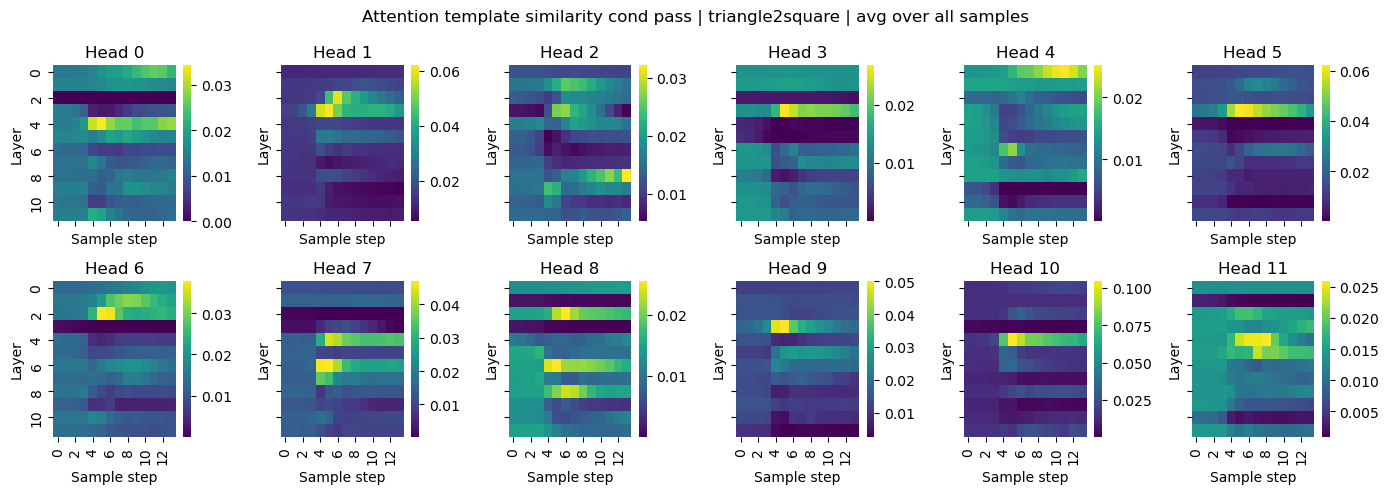

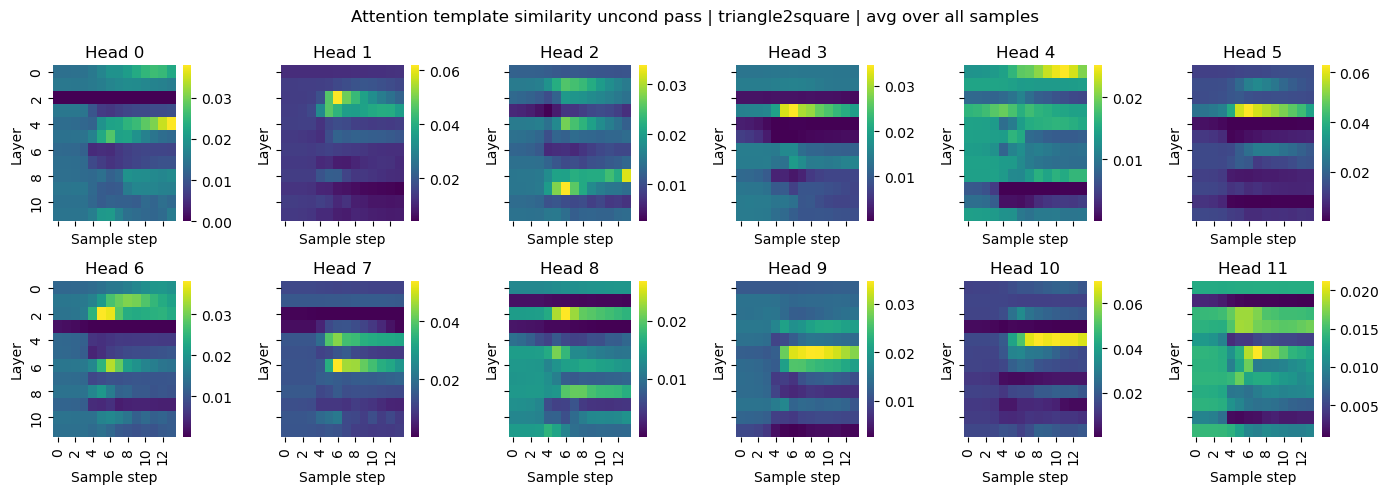

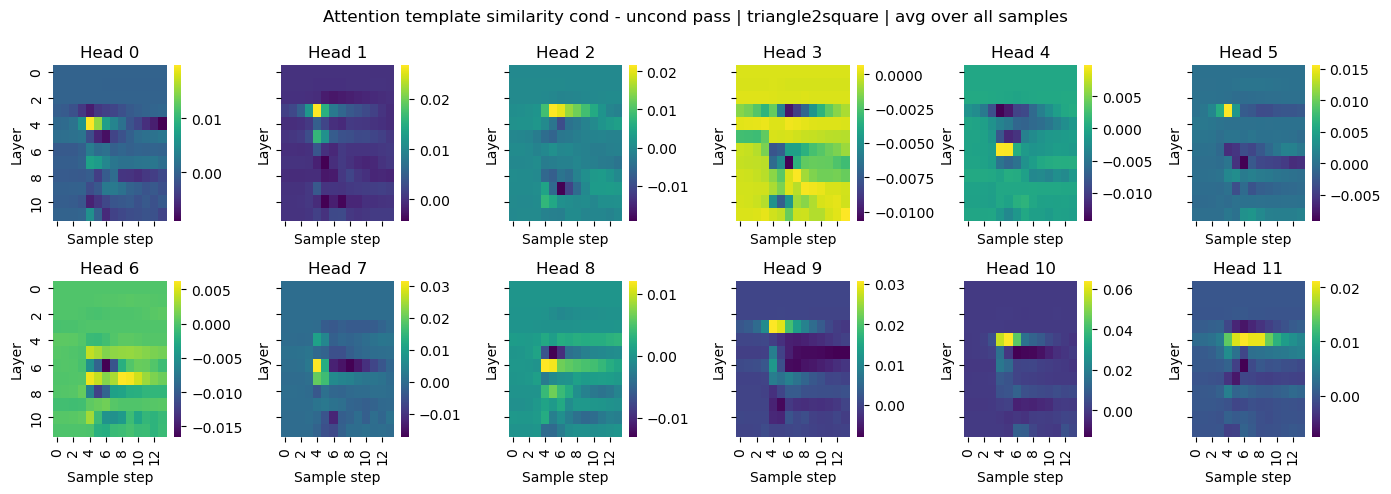

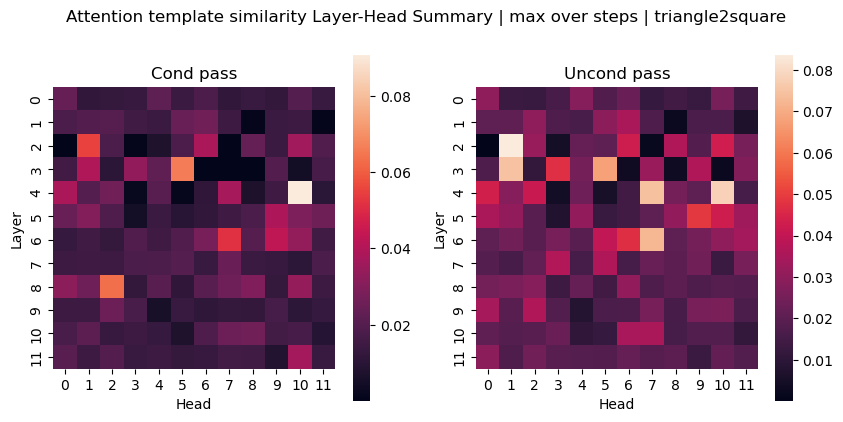

In [199]:
template_type = "triangle2square"
attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max")

  0%|          | 0/16 [00:00<?, ?it/s]

Failed to generate template for sample 9


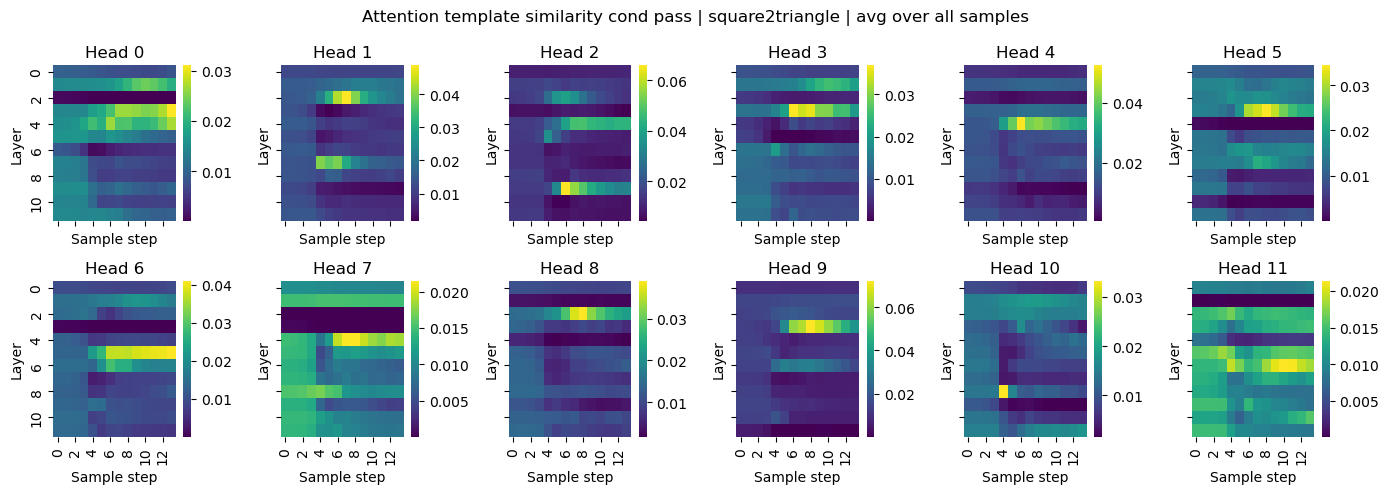

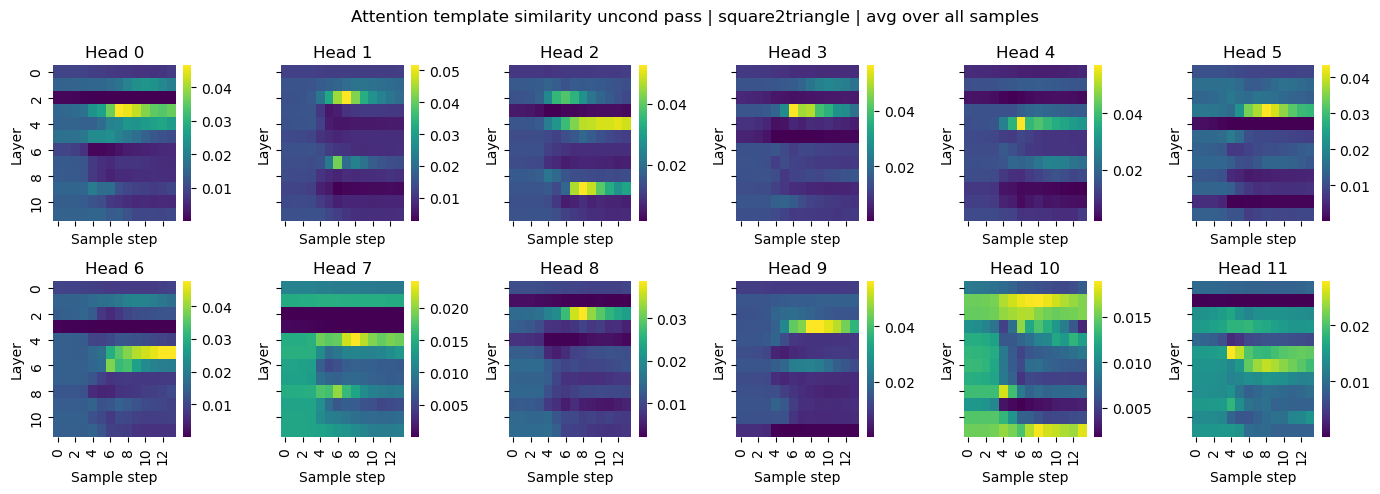

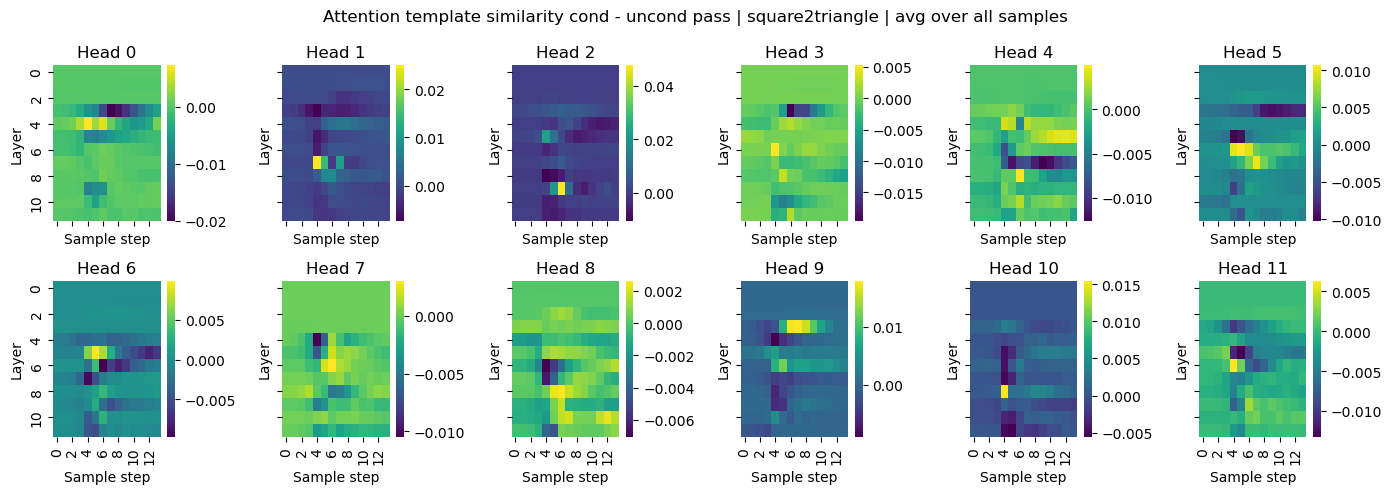

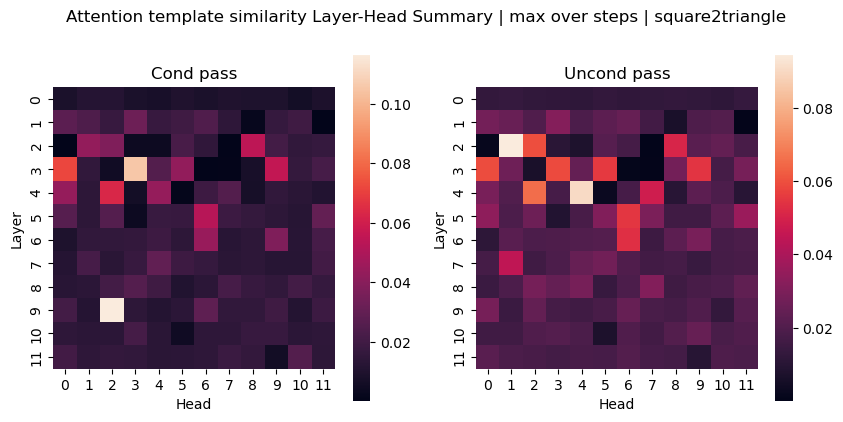

In [200]:
template_type = "square2triangle"
attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max")

  0%|          | 0/16 [00:00<?, ?it/s]

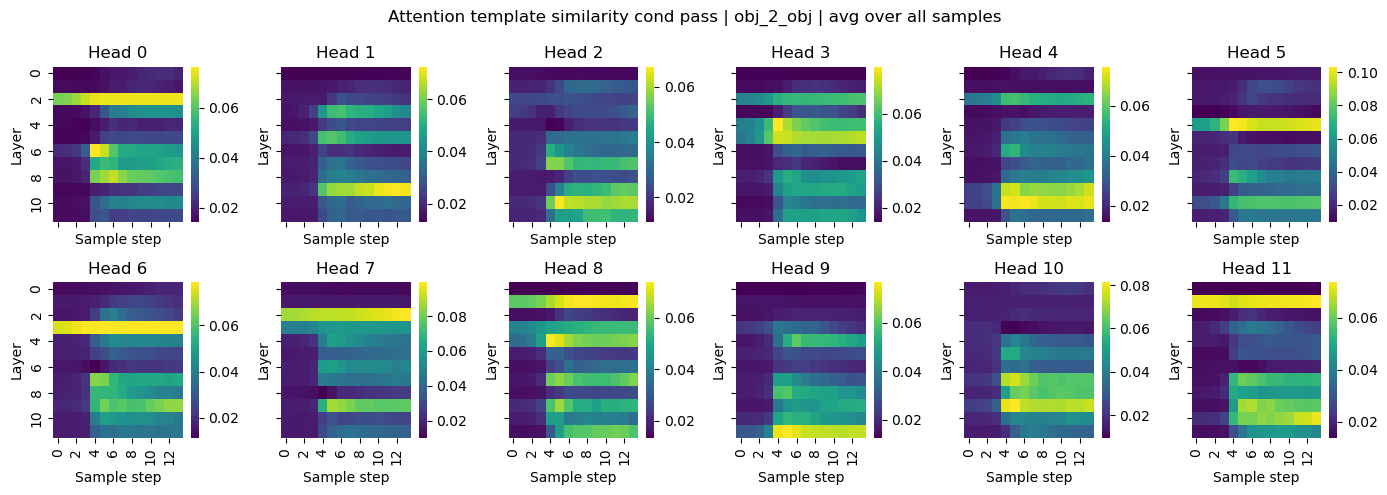

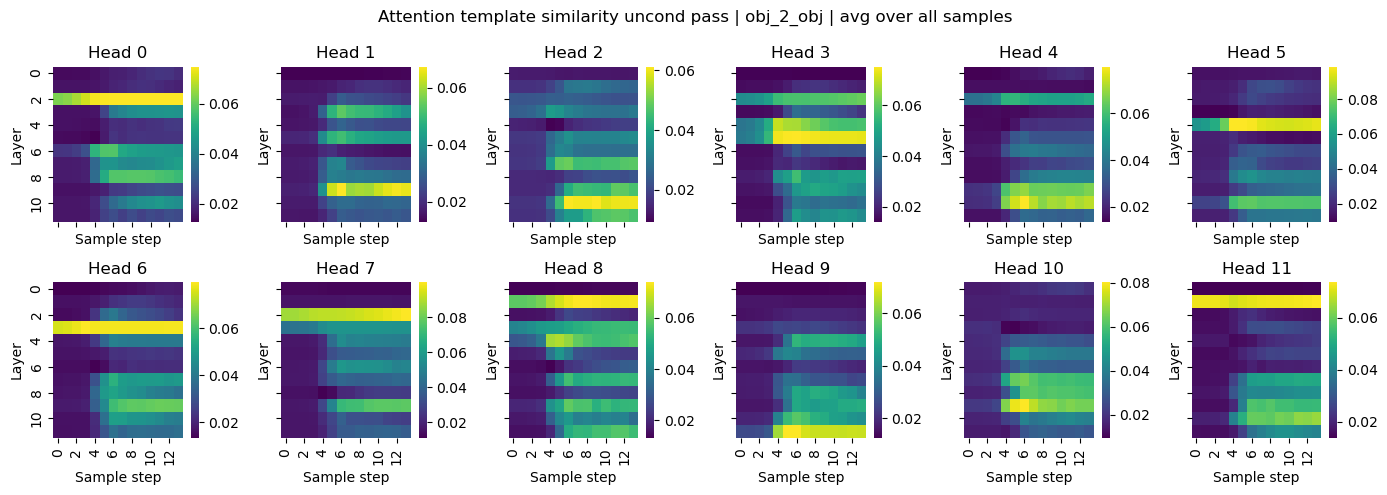

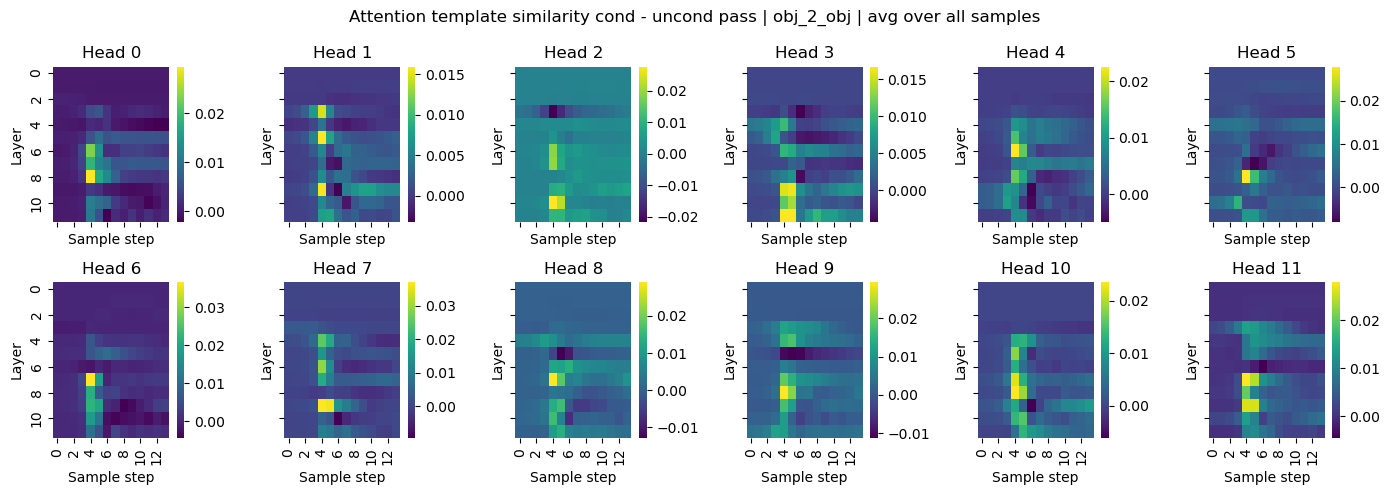

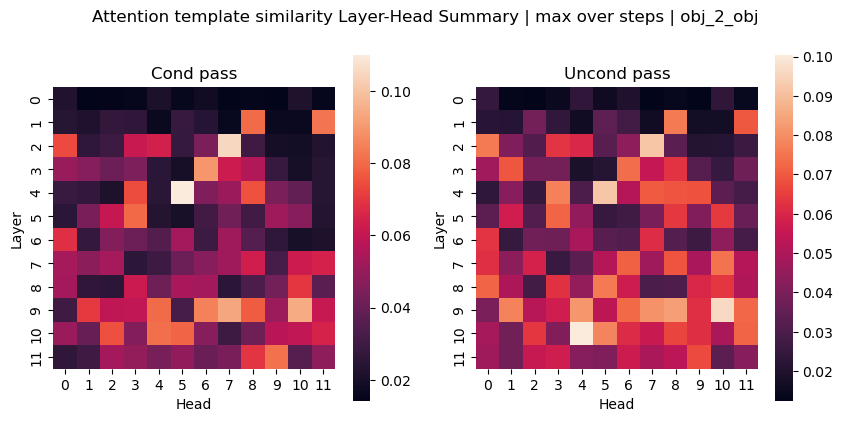

In [201]:
template_type = "obj_2_obj"
attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max")

  0%|          | 0/16 [00:00<?, ?it/s]

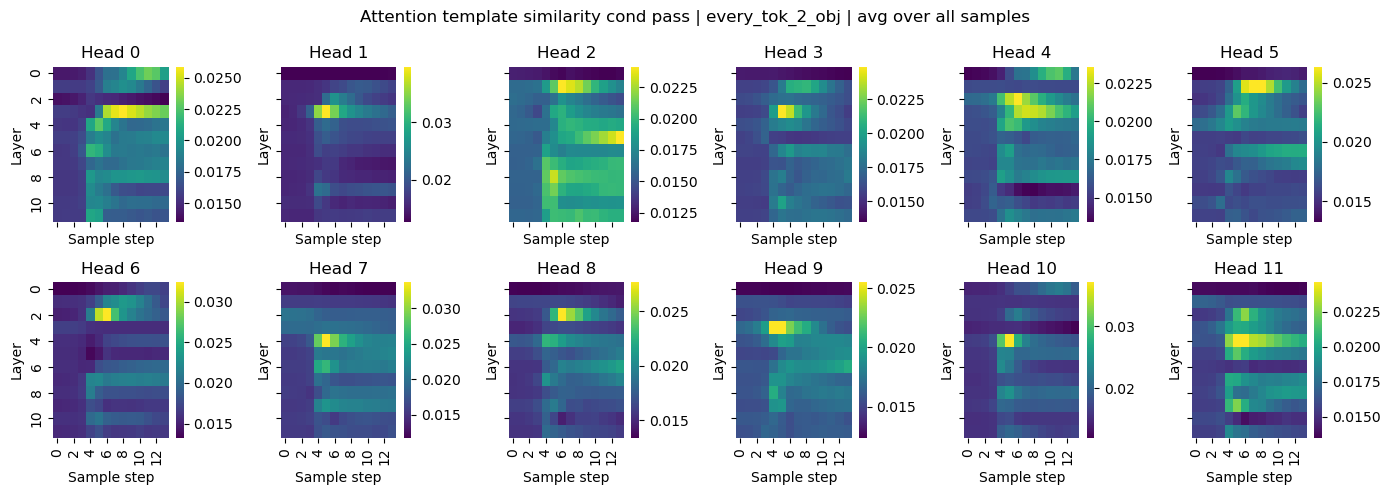

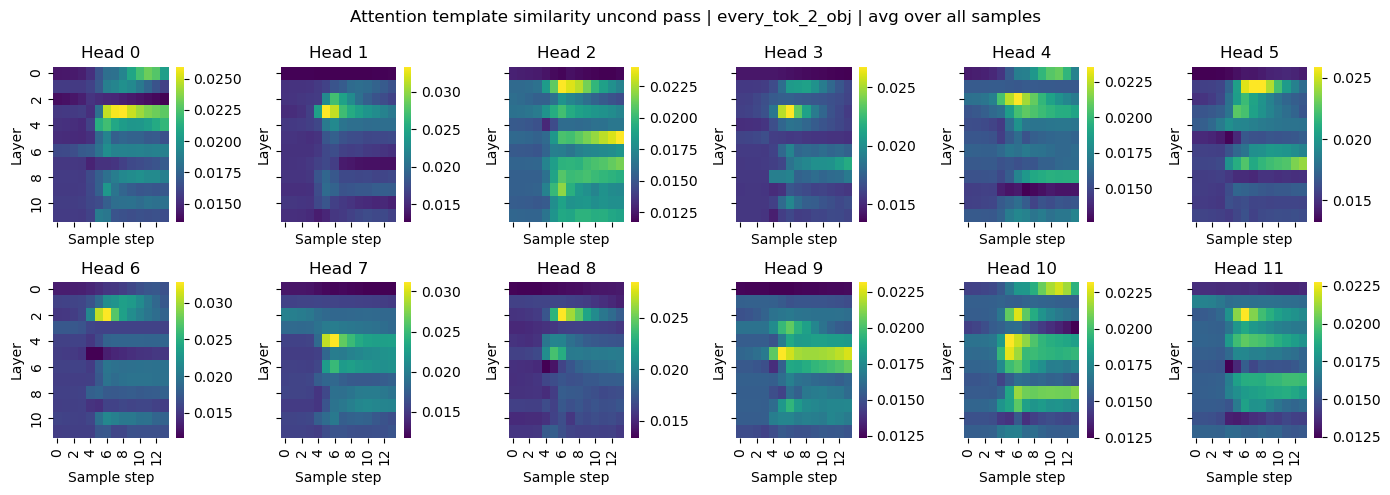

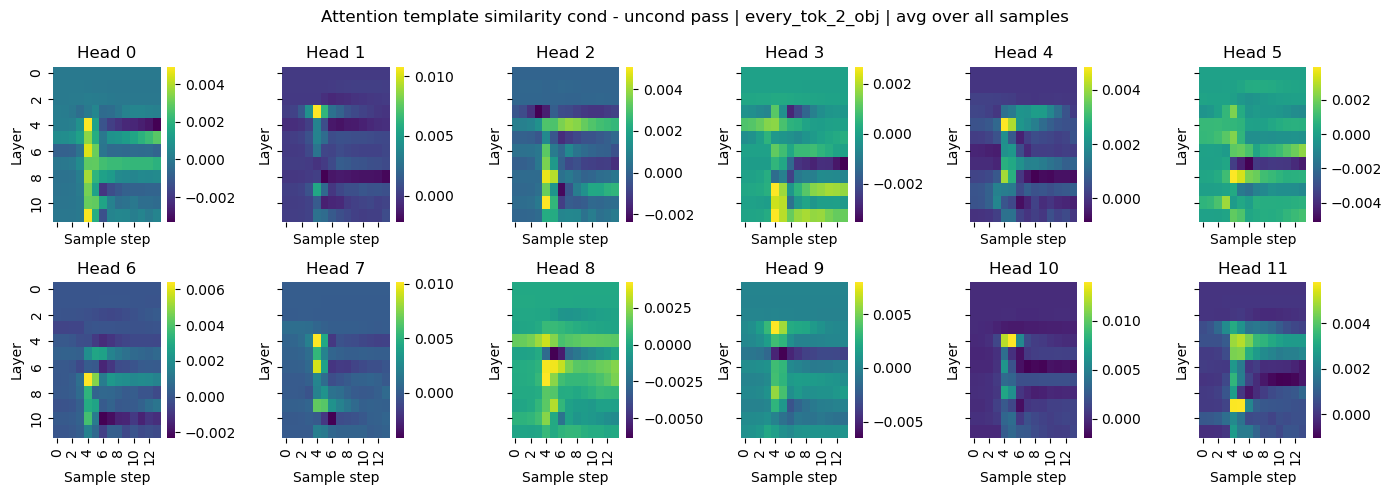

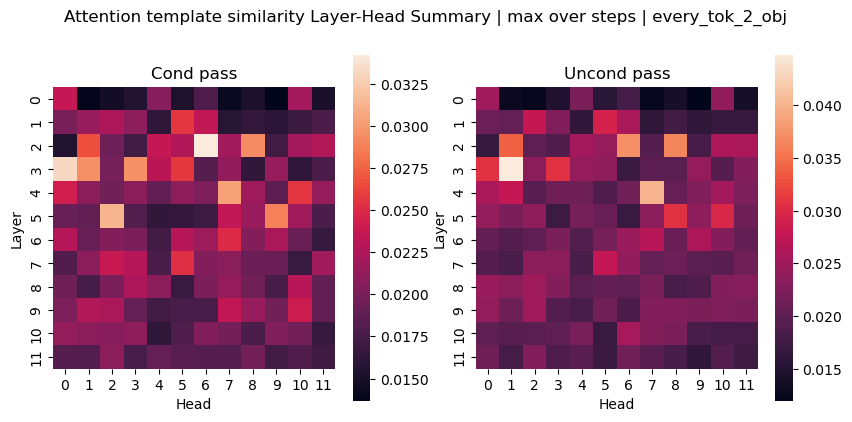

In [202]:
template_type = "every_tok_2_obj"
attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="max")

  0%|          | 0/16 [00:00<?, ?it/s]

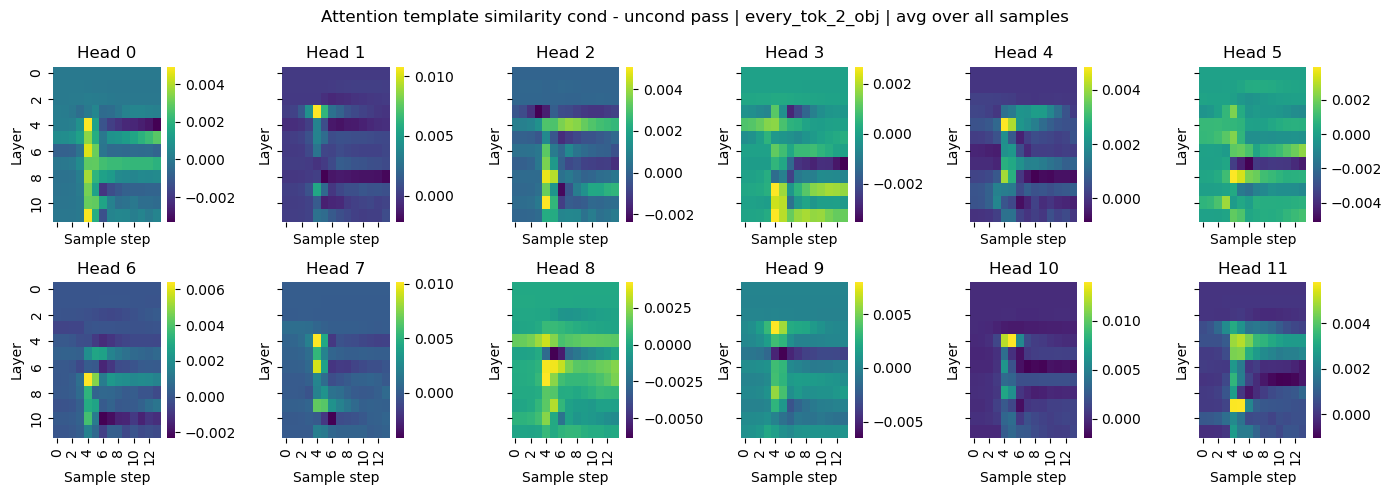

In [195]:
n_samples = 16
cond_slice = slice(n_samples, n_samples * 2)
uncond_slice = slice(0, n_samples)
template_type = "every_tok_2_obj"
attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))

  0%|          | 0/16 [00:00<?, ?it/s]

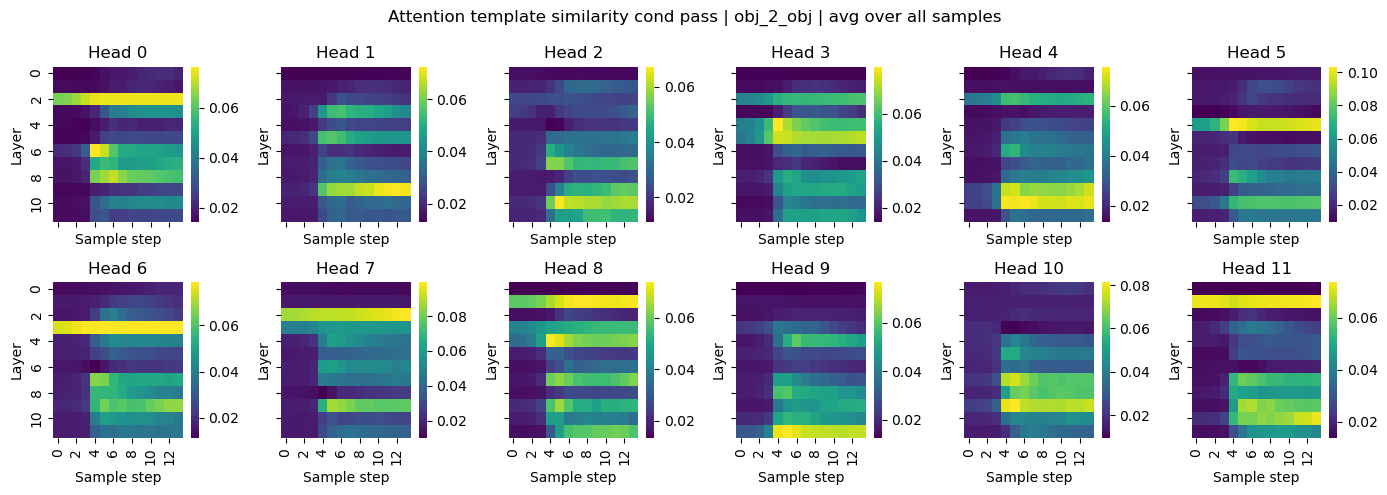

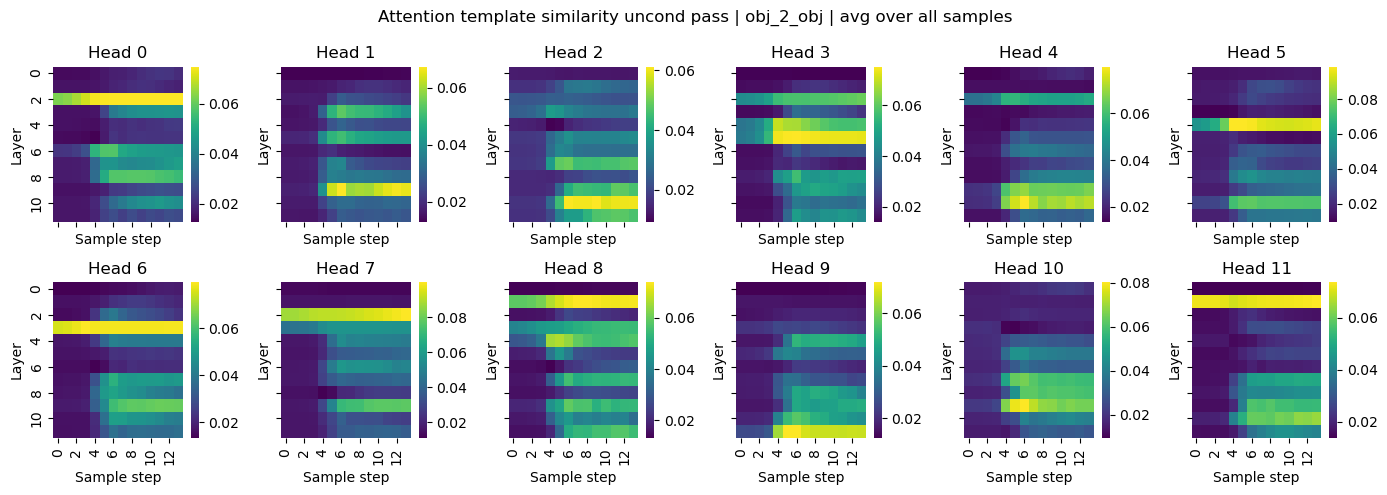

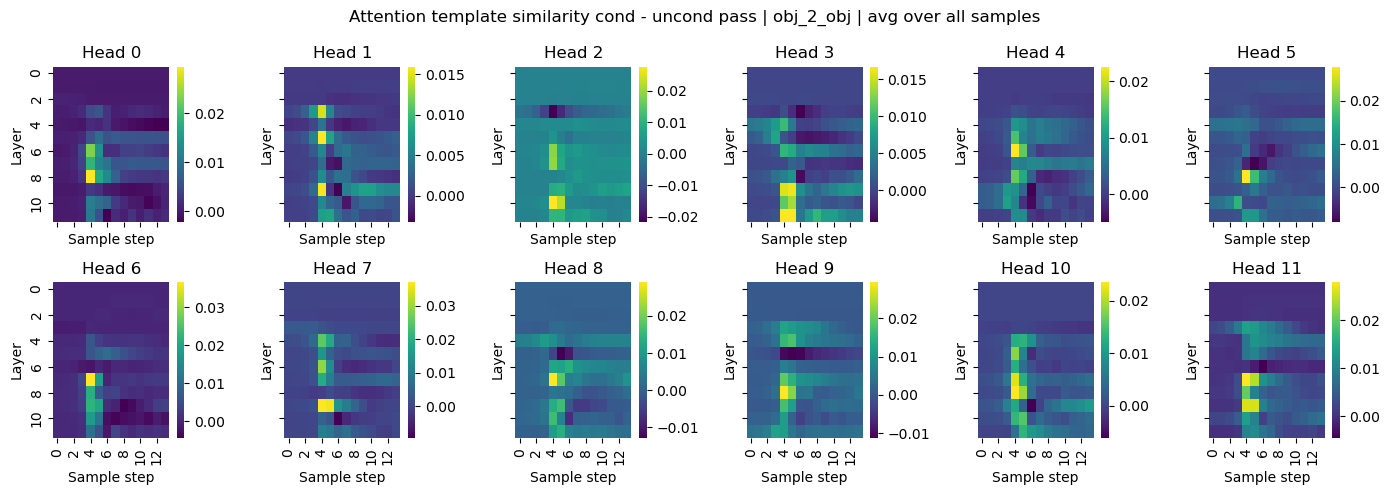

In [196]:
n_samples = 16
cond_slice = slice(n_samples, n_samples * 2)
uncond_slice = slice(0, n_samples)
template_type = "obj_2_obj"
attn_template_tsr, success_count = create_object_based_attention_template(output[0].images, template_type)
attn_template_uncond_cmb_tsr = postprocess_template(attn_template_tsr)
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice], 
                                        title_str=f"Attention template similarity cond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))
fig = plot_attention_layer_head_heatmaps(template_similarity_scores[:, :, cond_slice] - template_similarity_scores[:, :, uncond_slice], 
                                        title_str=f"Attention template similarity cond - uncond pass | {template_type}", 
                                        figsize=(14, 5), sample_idx=None, num_heads=12, share_clim=False, panel_shape=(2, 6))

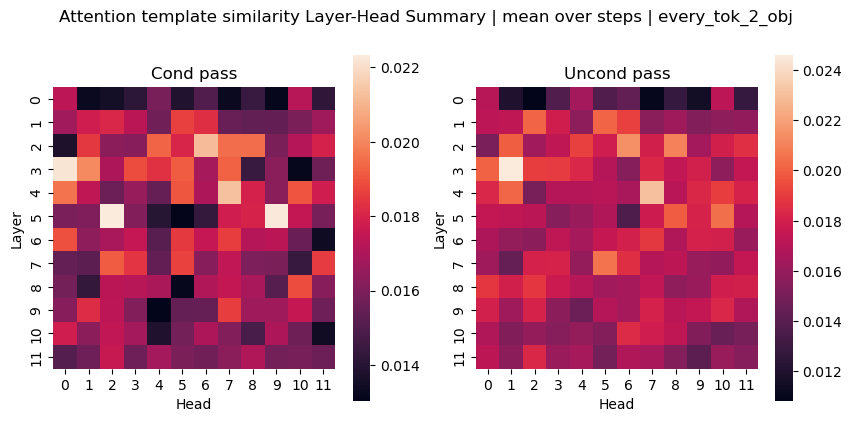

In [194]:
plot_layer_head_score_summary(template_similarity_scores, template_type, step_sum_type="mean")

In [182]:
template_similarity_scores.shape

torch.Size([12, 14, 32, 12])

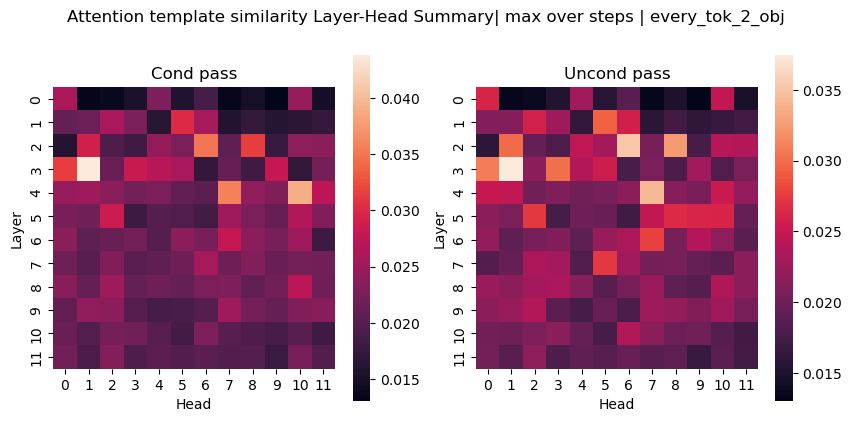

In [186]:
step_sum_type = "max"
cond_slice = slice(n_samples, n_samples * 2)
uncond_slice = slice(0, n_samples)
if step_sum_type == "max":
    temporal_summary = template_similarity_scores.max(dim=1).values
elif step_sum_type == "mean":
    temporal_summary = template_similarity_scores.mean(dim=1)
else:
    raise ValueError(f"Invalid step_sum_type: {step_sum_type}")
layer_head_summary = temporal_summary[:, cond_slice, :].mean(dim=-2).numpy()
plt.figure(figsize=(10, 4.5))
plt.subplot(1, 2, 1)
sns.heatmap(layer_head_summary)
plt.title("Cond pass")
plt.axis('image')
plt.ylabel("Layer")
plt.xlabel("Head")
plt.subplot(1, 2, 2)
layer_head_summary = temporal_summary[:, uncond_slice, :].mean(dim=-2).numpy()
sns.heatmap(layer_head_summary)
plt.title("Uncond pass")
plt.axis('image')
plt.ylabel("Layer")
plt.xlabel("Head")
plt.suptitle(f"Attention template similarity Layer-Head Summary | {step_sum_type} over steps | {template_type} ")
plt.show()

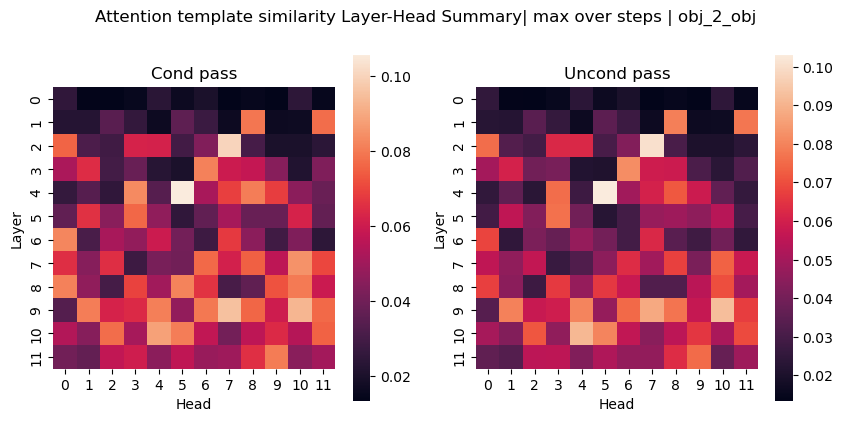

In [184]:
step_sum_type = "max"
cond_slice = slice(n_samples, n_samples * 2)
uncond_slice = slice(0, n_samples)
if step_sum_type == "max":
    temporal_summary = template_similarity_scores.max(dim=1).values
elif step_sum_type == "mean":
    temporal_summary = template_similarity_scores.mean(dim=1)
else:
    raise ValueError(f"Invalid step_sum_type: {step_sum_type}")
layer_head_summary = temporal_summary[:, cond_slice, :].mean(dim=-2)
plt.figure(figsize=(10, 4.5))
plt.subplot(1, 2, 1)
sns.heatmap(layer_head_summary.numpy())
plt.title("Cond pass")
plt.axis('image')
plt.ylabel("Layer")
plt.xlabel("Head")
plt.subplot(1, 2, 2)
layer_head_summary = temporal_summary[:, uncond_slice, :].mean(dim=-2)
sns.heatmap(layer_head_summary.numpy())
plt.title("Uncond pass")
plt.axis('image')
plt.ylabel("Layer")
plt.xlabel("Head")
plt.suptitle(f"Attention template similarity Layer-Head Summary| {step_sum_type} over steps | {template_type} ")
plt.show()

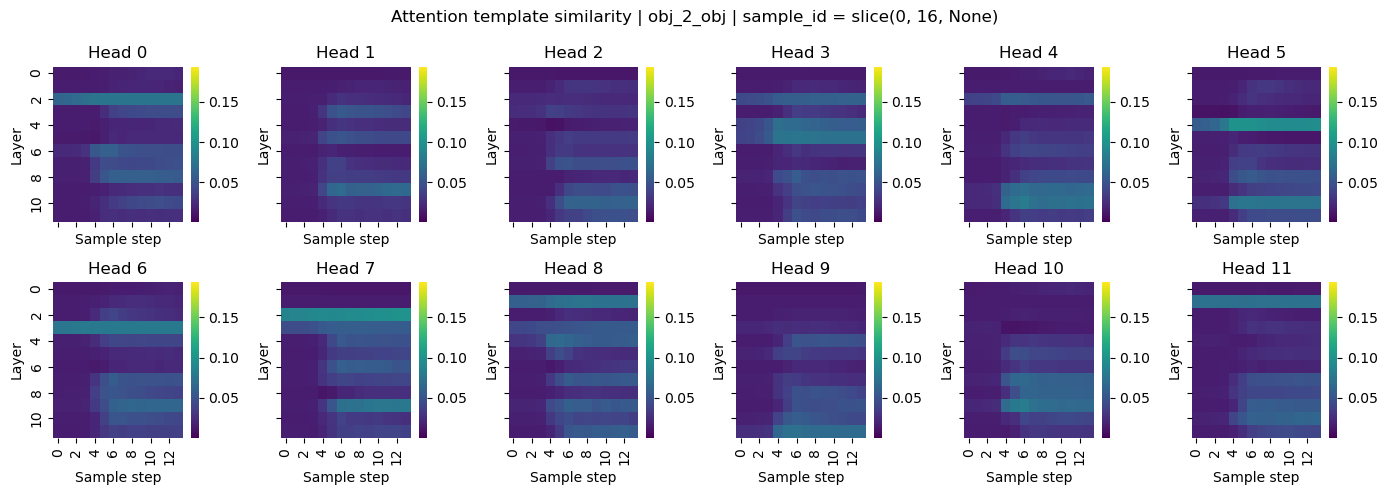

In [128]:
n_samples = 16
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                        title_str=f"Attention template similarity | {template_type}", 
                                        figsize=(14, 5), sample_idx=slice(0, n_samples), num_heads=12, share_clim=True, panel_shape=(2, 6))

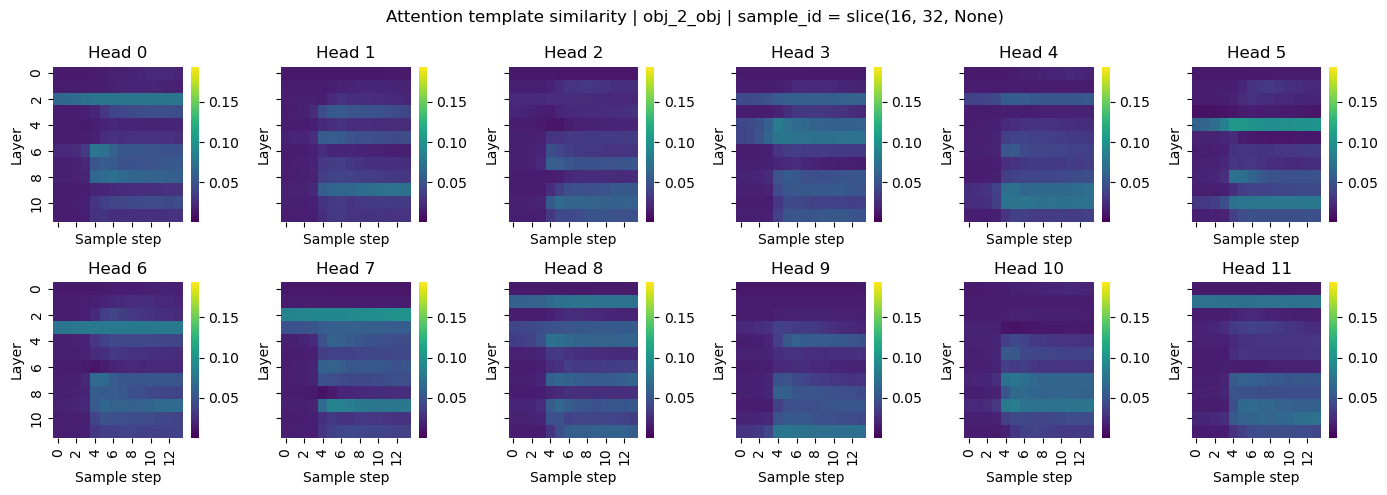

In [129]:
n_samples = 16
template_similarity_scores = (attn_map_stacked * attn_template_uncond_cmb_tsr).sum(dim=-1).sum(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                        title_str=f"Attention template similarity | {template_type}", 
                                        figsize=(14, 5), sample_idx=slice(n_samples, n_samples * 2), num_heads=12, share_clim=True, panel_shape=(2, 6))

### Scratch

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


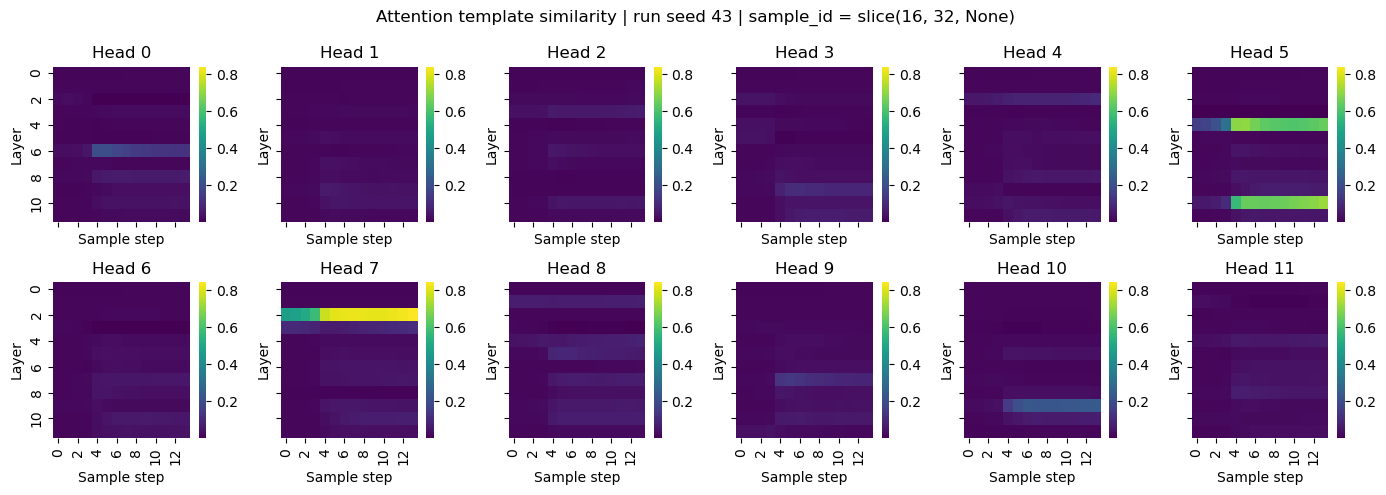

Computed attn entropy


In [64]:
attn_mat_template, _ = build_template_conv_attn_map(shifts=[(0, 1),], )
template_similarity_scores = (attn_map_stacked * attn_mat_template).sum(dim=-1).mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                         title_str="Attention template similarity | run seed 43", 
                                         figsize=(14, 5), sample_idx=slice(16, 32), num_heads=12, share_clim=True, panel_shape=(2, 6))
print("Computed attn entropy")

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


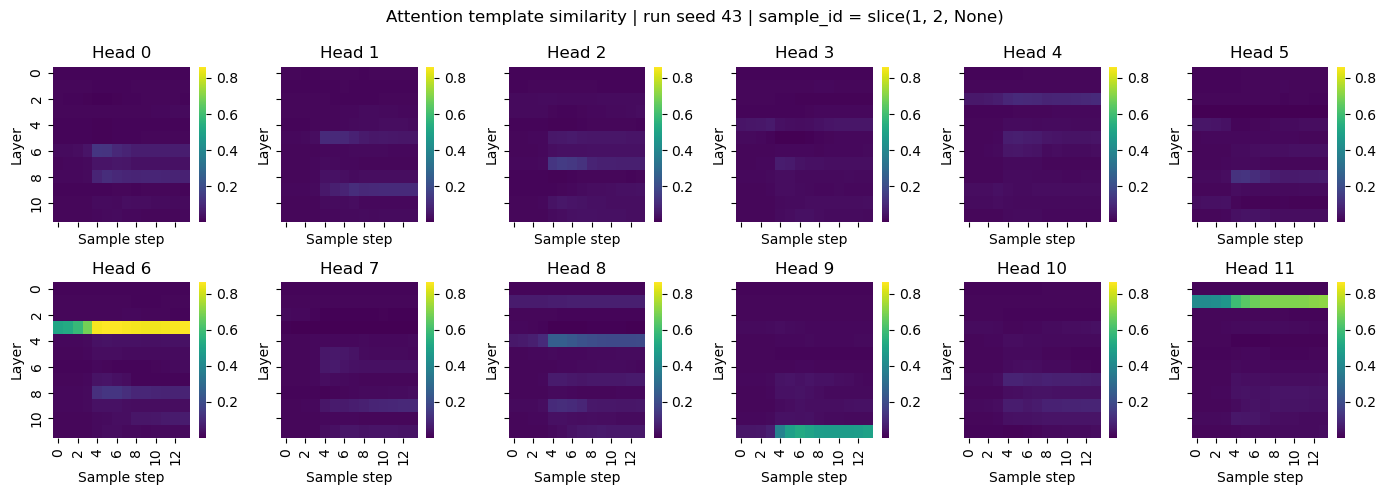

Computed attn entropy


In [59]:
attn_mat_template, _ = build_template_conv_attn_map(shifts=[(-1, 0),], )
template_similarity_scores = (attn_map_stacked * attn_mat_template).sum(dim=-1).mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                         title_str="Attention template similarity | run seed 43", 
                                         figsize=(14, 5), sample_idx=slice(1, 2), num_heads=12, share_clim=True, panel_shape=(2, 6))
print("Computed attn entropy")

attn_tsr_template.shape:  torch.Size([8, 8, 8, 8])
attn_mat_template.shape:  torch.Size([64, 64])


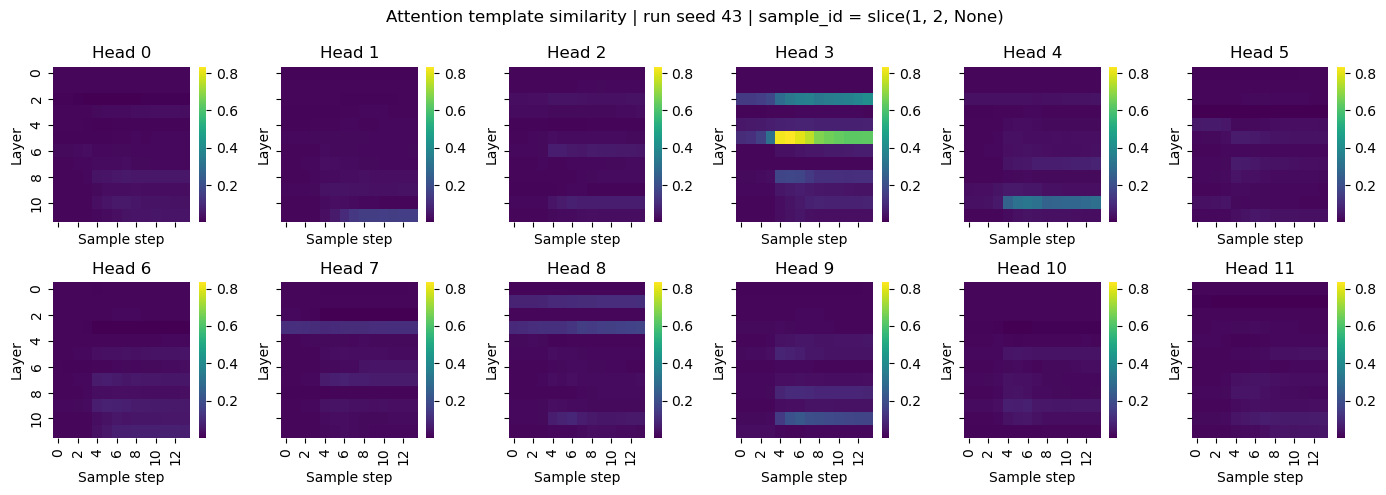

Computed attn entropy


In [60]:
attn_mat_template, _ = build_template_conv_attn_map(shifts=[(1, 0),], )
template_similarity_scores = (attn_map_stacked * attn_mat_template).sum(dim=-1).mean(dim=-1)
fig = plot_attention_layer_head_heatmaps(template_similarity_scores, 
                                         title_str="Attention template similarity | run seed 43", 
                                         figsize=(14, 5), sample_idx=slice(1, 2), num_heads=12, share_clim=True, panel_shape=(2, 6))
print("Computed attn entropy")